- **This code computes the decomposed solution of a Closed-Loop DRTO problem.**
- Using economic objective function
- The underlying control structure (modeled in the CLDRTO model) is an MPC, which can is solved using three different strategies: 1. unconstrained, 2. constrained using binaries, and 3. constrained using MPCC N.B.:strategy 2 not working
- The problem is posed as a scenario-based stochastic programming problem
- The case study is an affine multiple parallel bioreactor system from:*Gao, Ling. "Modeling and dynamics analyses of immobilized CSTR bioreactor using transfer function model." 2012 International Symposium on Information Technologies in Medicine and Education. Vol. 2. IEEE, 2012.*
- The uncertainty represented by the scenarios comes from the maximum specific growth rate (V_m) --> see matlab file

AUTHOR: Jose Matias <assumpcj@mcmaster.ca>
DATE: May 2023

In [1]:
using LinearAlgebra, JuMP, CPLEX, Ipopt, Plots, CSV, DataFrames, Distributions, LaTeXStrings

# Bioreactor Model

$\dfrac{d C}{d t} = D (C_{in} - C) - \dfrac{V_m C}{(K_s + C)} $ <br>
$ \dfrac{d P}{d t} = \dfrac{V_m C}{(K_s + C)} - DP $ <br>

where, <br>
$t$: time in hours \[h\] <br>
$C$: concentration of reactant (substrate) \[g/L\] <br>
$P$: concentration of product (biomass) \[g/L\] <br>
$C_{in}$: inlet concentration of substrate \[g/L\] <br>
$D$: ratio of flowrate to reactor volume \[1/h\] <br>
$V_m$: maximum reaction rate \[g/(h L)\] <br> 
$K_s$: reaction constant \[g/L\] <br>

- System measurement ($y$) - product concentration $P$ <br>
- System inputs ($u$) - inlet reactant concentration $C_{in}$ <br>
- Uncertain parameters ($\theta$) - maximum reaction rate $V_m$

In [2]:
# Sampling time
T = 1 #[h]

# Number of manipulated inputs
nu = 1
# Number of controlled outputs
ny = 1

# setting bounds (all arbitrary - not in deviation form!!) 
uMax = 2.4 # for tight constraints: 1.9 | for loose constraints: 5.0 or 10.0
uMin = 0.0;

yspMax = 1.2 
yspMin = 0.0;

# Building affine CL-DRTO models

## Model linearization
- linearization is done using Matlab's functions ss and c2d (see BioReactorLinearization.m)
- sample time $\Delta t$ is consider as 1h
- linearization around point: $V_m = 0.5$ \[g/(h L)\], $K_s = 0.2$ \[g/L\], $D = 0.5$ \[1/h\], $C_{in,0} = 1$ \[g/L\], $C_{0} = 0.358$ \[g/L\], and $P_{0} = 0.642$ \[g/L\]

which leads to: <br>
$\bar{x}_{k+1} = A \bar{x}_k + B \bar{u}_k$ <br>
$\bar{y}_k = C \bar{u}_k$

where, <br>
$\bar{x} = \begin{bmatrix}
\bar{C}\\
\bar{P}
\end{bmatrix} =
\begin{bmatrix}
C - C_0\\
P - P_0
\end{bmatrix}$<br>
$\bar{u} = \bar{C}_{in} = C_{in} - C_{in,0}$<br>
$\bar{y} = \bar{P} = P - P_0$

In [3]:
# Linearization point
u0 = 1.5
x0 = [0.7179;0.7821]
y0 = 0.7821

# 100 pre-computed models based on parametric uncertainty Vm (computed using matlab: BioReactorLinearization.m)
bioModels = CSV.read("C:\\Users\\MACC-Jose\\Documents\\GitHub\\BD\\CLDRTO Case Study 2 - Bioreactor\\BioreactorModel", DataFrame; header=false);
#print(bioModels)

CL-DRTO configuration

In [4]:
# DRTO sampling time
nDRTO = 4 # [h]
# Prediction horizon
pD = 20 + (8 - 1)# p = 8 *controller horizon  
# Input control horizon 
mD = 20
# Objective function: target tracking (deviation form)
pTrack = 1 - y0 # [g/L]
# Soft upper bounds on P weight (deviation form)
pUB = 1.05 - y0 # [g/L]
# objective function weight for P penalization term 
wP = 100;

DRTO model changes with the number of scenarios and parallel reactors

In [5]:
function DRTO_matrices(nReactors,nScenarios)
    # ATTENTION: Used for the monolithic solution. Generates an array of models
    # Several different models were already computed offline and saved in the "bioModel" array
    # This function extracts the models based on a fixed index grid that is generated based on the number of scenarios
    
    ###########
    # inputs: #
    ###########
    # nReactors - number of reactors in parallel
    # nScenarios - number of scenarios used in the stochastic optimization
    
    # picking up indexes equally spaced between 1 and 100 (including initial and end point) 
    # based on the desired number of scenarios
    if nScenarios == 1
        indexScen = 50 # nominal model --> index = 50
    else
        indexScen = [floor(Int, 1 + (ii - 1)*(100-1)/(nScenarios-1)) for ii in 1:nScenarios]
    end
    
    # building DRTO model
    A_drto = Array{Float64}(undef,nx,nx,nScenarios) 
    B_drto = Array{Float64}(undef,nx,nu,nScenarios) 

    for kk in 1:nScenarios

        index_temp = indexScen[kk]

        A_drto[:,:,kk] = kron(I(nReactors),Matrix(bioModels[2*(index_temp - 1) + 1:2*(index_temp - 1) + 2,1:2]))
        B_drto[:,:,kk] = repeat(bioModels[2*(index_temp - 1) + 1:2*(index_temp - 1) + 2,3], outer = [nReactors, 1, 1])

    end

    # mapping states to measurements is the same for all models
    C_drto = repeat([0 1/nReactors], outer = [1, nReactors])
    
    return Dict('A' => A_drto, 'B' => B_drto, 'C' => C_drto)
end;

In [6]:
function DRTO_matrix(nReactors,nScenario,nScenTotal)
    # ATTENTION: Used for the decomposed solution. Generates a single model
    # Several different models were already computed offline and saved in the "bioModel" array
    # This function extracts the model of interest based on the index "nScenario"
  
    ###########
    # inputs: #
    ###########
    # nReactors - number of reactors in parallel
    # nScenario - index the of scenario used in the stochastic optimization
    # nScenTotal - total number of scenario used in the stochastic optimization
    
    if nScenTotal == 1
        index_temp = 50 # nominal model --> index = 50
    else
        indexScen = [floor(Int, 1 + (ii - 1)*(100-1)/(nScenTotal-1)) for ii in 1:nScenTotal]
        index_temp = indexScen[nScenario]
    end
  
    # building DRTO model
    A_drto = kron(I(nReactors),Matrix(bioModels[2*(index_temp - 1) + 1:2*(index_temp - 1) + 2,1:2]))
    B_drto = repeat(bioModels[2*(index_temp - 1) + 1:2*(index_temp - 1) + 2,3], outer = [nReactors, 1, 1])

    # mapping states to measurements is the same for all models
    C_drto = repeat([0 1/nReactors], outer = [1, nReactors]);
    
    return Dict('A' => A_drto, 'B' => B_drto, 'C' => C_drto)
end;

# Building MPC model

Controller configuration

In [7]:
# MPC sampling time
nMPC = 1 # [h]

# Controller configuration
# Output prediction horizon
p = 8
# Input control horizon 
m = 2
# Output weights
q = 1
# Input weights 
r = 1;

Notes:
- Using nominal model(indexScen = 50)
- For the description of how the MPC matrices (with disturbance model) are built, check script: *CLDRTO with unconstrained MPC - uncertain plant test*

In [8]:
function MPC_matrices(nReactors)
    ###########
    # inputs: #
    ###########
    # nReactors - number of reactors in parallel
    
    # extracting the matrices from the model array computed previously
    nNom = 50 # nominal model --> index = 50
    
    A = kron(I(nReactors),Matrix(bioModels[2*(nNom - 1) + 1:2*(nNom - 1) + 2,1:2])) 
    B = repeat(bioModels[2*(nNom - 1) + 1:2*(nNom - 1) + 2,3], outer = [nReactors, 1])
    C = repeat([0 1/nReactors], outer = [1, nReactors])
    
    # adding disturbance model
    Ad = [A zeros(nx,ny); zeros(ny,nx) I(ny)]
    Bd = [B; zeros(ny,nu)]
    Cd = [C ones(ny,ny)]
    
    # building matrices for MPC
    Psi = Cd*Ad
    for ii in 2:p
        Psi = [Psi;  Cd*Ad^ii]
    end

    # Computing Dynamic Matrix
    a = Cd*Bd
    for ii in 2:p
        a = [a; Cd*Ad^(ii - 1)*Bd]
    end
    DynM = a

    for ii in 1:(m - 2)
        a = [zeros(ny,nu);a[1:(p-1)*ny,:]]
        DynM = [DynM  a]
    end

    # adjusting dynamic matrix for since p > m (last column)
    b = Cd*Bd

    Ai = I(nx+1) # adding disturbance to the states
    for ii = 1:(p - m)
        Ai = Ai + Ad^ii
        b = [b;Cd*Ai*Bd]
    end

    Theta=[DynM [zeros(ny*(m-1),nu);b]]
    
    # Creating Qbar and Rbar matrices
    Qbar = Diagonal([q for ii in 1:p])
    Rbar = Diagonal([r for ii in 1:m])

    # Creating input movement OF penalty matrix 
    M=[zeros((m-1)*nu,nu) I(nu*(m-1)); zeros(nu) zeros(nu,nu*(m-1))]
    Ibar=[I(nu); zeros(nu*(m-1),nu)]
    IM = I(nu*m) - M';
    
    # Matrix H
    H = Theta'*Qbar*Theta + IM'*Rbar*IM;
    
    return Dict('A' => A, 'B' => B, 'C' => C, 'H' => H, 'Θ' => Theta, 'Ψ' => Psi, 'Q' => Qbar, 'I' => Ibar, 'R' => Rbar, 'M' => IM)
end;

# Solving CL-DRTO Multiscenario Problem (monolithic)
 - Check details in script *Monolithic CLDRTO*
 - For the description of the different solution strategies, check *Different Strategies to solve constrained MPC within CLDRTO*

In [9]:
# Parameters for MPC solution
# matrix to compute the gradients of the input bound constraints
conMatrix = [I(m); -I(m)]; 

# big-M implementation
bigM_mu = 1000
bigM_u = 100

# weight complementarity relaxation OF term
pi_bar = 10^3;

In [10]:
## Modeling the sub problem (scenario) -- modeling inside a function
function MS_CLDRTO(xInit,uInit,nReac,nScen,pScen,solNom,option)
    ###########
    # inputs: #
    ###########
    # xInit - states at the current iteration (beginning of DRTO horizon)
    # uInit - inputs at the current iteration, already implemented on the plant
    # nReac - number of parallel reactors
    # nScen - number of scenarios used in the problem (only one branching)
    # pScen - probability of the scenarios
    # solNom - nominal solution
    # option - strategy for solving MPC

    # Creating MPC matrices
    mpc = MPC_matrices(nReac)
    
    # Creating DRTO matrices
    drto = DRTO_matrices(nReac,nScen)

    # Define model
    if option == 3 || option == 1
        model_ms = Model(Ipopt.Optimizer)
        set_optimizer_attribute(model_ms, "max_cpu_time", 300.0) # 5 min
    else 
        model_ms = Model(CPLEX.Optimizer)
        set_optimizer_attribute(model_ms, "CPX_PARAM_TILIM", 300.0) # 5 min
    end
    set_silent(model_ms)
    
    ####################
    # Set up variables #
    ####################
    # DRTO model variables
    @variable(model_ms, xDRTO[1:pD,1:nx,1:nScen])
    @variable(model_ms, yDRTO[1:pD,1:nScen])
    
    # MPC model variables
    @variable(model_ms, xMPC[1:pD,1:nx,1:nScen])
    @variable(model_ms, yMPC[1:pD,1:nScen])
    
    # MPC <-> DRTO model deviation
    @variable(model_ms, de[1:pD,1:nScen])
    
    # inputs computed by MPCs
    @variable(model_ms, u[1:pD,1:m,1:nScen])
    if option == 1
        @variable(model_ms, u_w_c[1:pD,1:m,1:nScen]) # inputs w/o clipping
    
        # input clipping 
        @variable(model_ms, mu_lb[1:pD,1:m,1:nScen] ≥ 0)
        @variable(model_ms, eta_lb[1:pD,1:m,1:nScen] ≥ 0)
        @variable(model_ms, mu_ub[1:pD,1:m,1:nScen] ≥ 0)
        @variable(model_ms, eta_ub[1:pD,1:m,1:nScen] ≥ 0)       
    end
    
    # setpoints for the controllers sent to the plant (CL-DRTO degrees of freedom)
    @variable(model_ms, (yspMin - y0) ≤ ysp[1:pD,1:nScen] ≤ (yspMax - y0))
    
    # slacks for P soft constraint
    @variable(model_ms, delta_p[1:pD,1:nScen] ≥ 0)
    
    if option == 2 || option == 3
        @variable(model_ms, mu_g[1:mD,1:(2*m),1:nScen] ≥ 0) # upper and lower bounds for each input
    end
    if option == 2
        @variable(model_ms, Y_lb[1:mD,1:m,1:nScen], Bin, start = 0) # Binaries for big-M implementation
        @variable(model_ms, Y_ub[1:mD,1:m,1:nScen], Bin, start = 0) 
    end
    
    ########################
    # Set up initial guess #
    ########################
    if solNom isa Dict
        for ss in 1:nScen
            for ii in 1:pD
                set_start_value(yDRTO[ii,ss], solNom['y'][ii,1]) 
                set_start_value(yMPC[ii,ss], solNom['c'][ii,1])
                set_start_value(ysp[ii,ss], solNom['s'][ii,1])

                for rr in 1:nReac # when nReac increases, the number of states change!
                    for xx in 1:2 # N.B. nx/reactor is hardcoded here... (maybe use nx/reactor as a function input) 
                        set_start_value(xDRTO[ii,xx + (rr - 1)*2,ss], solNom['x'][ii,xx,1])    
                        set_start_value(xMPC[ii,xx + (rr - 1)*2,ss], solNom['m'][ii,xx,1])           
                    end # end xx
                end # number 
                
                for uu in 1:m
                    set_start_value(u[ii,uu,ss], solNom['u'][ii,uu,1])
                end # end of uu
            end # eend of ii
        end # end of ss
    end # end of if
    
    ######################################
    # Set up constraints and expressions #
    ######################################
    # Model Dynamic for Dynamic RTO
    @constraint(model_ms, CLDRTO_dyn_model_1[ss=1:nScen], xDRTO[1,:,ss] .== drto['A'][:,:,ss]*xInit + drto['B'][:,:,ss]*uInit)
    @constraint(model_ms, CLDRTO_dyn_model[kk=1:(pD - 1),ss=1:nScen], xDRTO[kk + 1,:,ss] .== drto['A'][:,:,ss]*xDRTO[kk,:,ss] + drto['B'][:,:,ss]*u[kk,1,ss])
    @constraint(model_ms, CLDRTO_model_out[kk=1:pD,ss=1:nScen], yDRTO[kk,ss] == dot(drto['C'],xDRTO[kk,:,ss]))
    
    # fixing setpoint changes after mD
    @constraint(model_ms, control_horizon[kk=(mD+1):pD,ss=1:nScen], u[kk,1,ss] .== u[mD,1,ss])
    
    # P soft constraints
    @constraint(model_ms, soft_P[kk=1:pD,ss=1:nScen], yDRTO[kk,ss] - delta_p[kk,ss] ≤ pUB)
    
    # nonanticipativity constraints
    @constraint(model_ms, nonAnt[kk=1:nDRTO,ss=2:nScen], ysp[kk,1] - ysp[kk,ss] == 0.0);
    
    ################
    # MPC solution #
    ################    
    if option == 1
        # Model Dynamic for Controller
        @constraint(model_ms, MPC_dyn_model_1[ss=1:nScen], xMPC[1,:,ss] .== mpc['A']*xInit + mpc['B']*uInit)
        @constraint(model_ms, MPC_dyn_model[kk=1:(pD - 1),ss=1:nScen], xMPC[kk + 1,:,ss] .== mpc['A']*xMPC[kk,:,ss] + mpc['B']*u_w_c[kk,1,ss])
        @constraint(model_ms, MPC_model_out[kk=1:pD,ss=1:nScen], yMPC[kk,ss] == dot(mpc['C'],xMPC[kk,:,ss]))

        #  Model deviation
        @constraint(model_ms, MPC_model_dev[kk=1:pD,ss=1:nScen], de[kk,ss] == yDRTO[kk,ss] - yMPC[kk,ss])
        
        @expression(model_ms, cfT_1[ss=1:nScen], (mpc['Ψ']*[xMPC[1,:,ss];de[1,ss]] - ysp[1:p,ss])'*mpc['Q']*mpc['Θ'] - uInit'*mpc['I']'*mpc['R']*mpc['M'])
        @expression(model_ms, cfT[kk=2:mD,ss=1:nScen], (mpc['Ψ']*[xMPC[kk,:,ss];de[kk,ss]] - ysp[kk:(kk + p - 1),ss])'*mpc['Q']*mpc['Θ'] - u_w_c[kk-1,1,ss]'*mpc['I']'*mpc['R']*mpc['M'])
        
        # Unconstrained MPC solution  
        @constraint(model_ms, MPC_sol_1[ss=1:nScen], mpc['H']*u_w_c[1,:,ss] + cfT_1[ss]' .== 0)
        @constraint(model_ms, MPC_sol[kk=2:mD,ss=1:nScen], mpc['H']*u_w_c[kk,:,ss] + cfT[kk,ss]' .== 0)
        
        # input clipping
        @constraint(model_ms, ic_1[kk = 1:mD,uu = 1:m,ss = 1:nScen], u[kk,uu,ss] == u_w_c[kk,uu,ss] - mu_ub[kk,uu,ss] + mu_lb[kk,uu,ss])
        @constraint(model_ms, ic_2[kk = 1:mD,uu = 1:m,ss = 1:nScen], (uMax - u0) - u[kk,uu,ss] == eta_ub[kk,uu,ss])
        @constraint(model_ms, ic_3[kk = 1:mD,uu = 1:m,ss = 1:nScen], eta_ub[kk,uu,ss]*mu_ub[kk,uu,ss] ≤ 1e-6)
        @constraint(model_ms, ic_4[kk = 1:mD,uu = 1:m,ss = 1:nScen], u[kk,uu,ss] - (uMin - u0) == eta_lb[kk,uu,ss])
        @constraint(model_ms, ic_5[kk = 1:mD,uu = 1:m,ss = 1:nScen], eta_lb[kk,uu,ss]*mu_lb[kk,uu,ss] ≤ 1e-6)
        
    elseif option == 2
        # Model Dynamic for Controller
        @constraint(model_ms, MPC_dyn_model_1[ss=1:nScen], xMPC[1,:,ss] .== mpc['A']*xInit + mpc['B']*uInit)
        @constraint(model_ms, MPC_dyn_model[kk=1:(pD - 1),ss=1:nScen], xMPC[kk + 1,:,ss] .== mpc['A']*xMPC[kk,:,ss] + mpc['B']*u[kk,1,ss])
        @constraint(model_ms, MPC_model_out[kk=1:pD,ss=1:nScen], yMPC[kk,ss] == dot(mpc['C'],xMPC[kk,:,ss]))

        #  Model deviation
        @constraint(model_ms, MPC_model_dev[kk=1:pD,ss=1:nScen], de[kk,ss] == yDRTO[kk,ss] - yMPC[kk,ss])

        # sequence of Setpoints
        @expression(model_ms, cfT_1[ss=1:nScen], (mpc['Ψ']*[xMPC[1,:,ss];de[1,ss]] - ysp[1:p,ss])'*mpc['Q']*mpc['Θ'] - uInit'*mpc['I']'*mpc['R']*mpc['M'])
        @expression(model_ms, cfT[kk=2:mD,ss=1:nScen], (mpc['Ψ']*[xMPC[kk,:,ss];de[kk,ss]] - ysp[kk:(kk + p - 1),ss])'*mpc['Q']*mpc['Θ'] - u[kk-1,1,ss]'*mpc['I']'*mpc['R']*mpc['M'])

        # Constrained with binaries
        # 1. stationarity
        @constraint(model_ms, MPC_sol_1[ss=1:nScen], u[1,:,ss]'*mpc['H'] + cfT_1[ss] +  mu_g[1,:,ss]'*conMatrix .== 0)
        @constraint(model_ms, MPC_sol[kk=2:mD,ss=1:nScen], u[kk,:,ss]'*mpc['H'] + cfT[kk,ss] + mu_g[kk,:,ss]'*conMatrix .== 0)

        # 2. primal feasibility
        @constraint(model_ms, g_u_u[kk=1:mD,uu=1:m,ss=1:nScen], u[kk,uu,ss] - (uMax - u0) ≤ 0)
        @constraint(model_ms, g_u_l[kk=1:mD,uu=1:m,ss=1:nScen], (uMin - u0) - u[kk,uu,ss] ≤ 0)
    
        # 3. complementarity --> using big-M implementation
        @constraint(model_ms, bigM_1[kk=1:mD,uu=1:m,ss=1:nScen], mu_g[kk,uu,ss] ≤ bigM_mu*Y_ub[kk,uu,ss])
        @constraint(model_ms, bigM_2[kk=1:mD,uu=1:m,ss=1:nScen], mu_g[kk,uu + m,ss] ≤ bigM_mu*Y_lb[kk,uu,ss])
        @constraint(model_ms, bigM_3[kk=1:mD,uu=1:m,ss=1:nScen], u[kk,uu,ss] - (uMax - u0) ≥ -bigM_u*(1 - Y_ub[kk,uu,ss]))
        @constraint(model_ms, bigM_4[kk=1:mD,uu=1:m,ss=1:nScen], (uMin - u0) - u[kk,uu,ss] ≥ -bigM_u*(1 - Y_lb[kk,uu,ss]))
        
        @constraint(model_ms, compSlack[kk=1:mD,uu=1:m,ss=1:nScen], Y_ub[kk,uu,ss] + Y_lb[kk,uu,ss] ≤ 1)
    
    elseif option == 3
        # Model Dynamic for Controller
        @constraint(model_ms, MPC_dyn_model_1[ss=1:nScen], xMPC[1,:,ss] .== mpc['A']*xInit + mpc['B']*uInit)
        @constraint(model_ms, MPC_dyn_model[kk=1:(pD - 1),ss=1:nScen], xMPC[kk + 1,:,ss] .== mpc['A']*xMPC[kk,:,ss] + mpc['B']*u[kk,1,ss])
        @constraint(model_ms, MPC_model_out[kk=1:pD,ss=1:nScen], yMPC[kk,ss] == dot(mpc['C'],xMPC[kk,:,ss]))

        #  Model deviation
        @constraint(model_ms, MPC_model_dev[kk=1:pD,ss=1:nScen], de[kk,ss] == yDRTO[kk,ss] - yMPC[kk,ss])

        # sequence of Setpoints
        @expression(model_ms, cfT_1[ss=1:nScen], (mpc['Ψ']*[xMPC[1,:,ss];de[1,ss]] - ysp[1:p,ss])'*mpc['Q']*mpc['Θ'] - uInit'*mpc['I']'*mpc['R']*mpc['M'])
        @expression(model_ms, cfT[kk=2:mD,ss=1:nScen], (mpc['Ψ']*[xMPC[kk,:,ss];de[kk,ss]] - ysp[kk:(kk + p - 1),ss])'*mpc['Q']*mpc['Θ'] - u[kk-1,1,ss]'*mpc['I']'*mpc['R']*mpc['M'])

        # Constrained with MPCC
        # 1. stationarity
        @constraint(model_ms, MPC_sol_1[ss=1:nScen], u[1,:,ss]'*mpc['H'] + cfT_1[ss] +  mu_g[1,:,ss]'*conMatrix .== 0)
        @constraint(model_ms, MPC_sol[kk=2:mD,ss=1:nScen], u[kk,:,ss]'*mpc['H'] + cfT[kk,ss] + mu_g[kk,:,ss]'*conMatrix .== 0)

        # 2. primal feasibility
        @constraint(model_ms, MPC_c_upper[kk=1:mD,uu=1:m,ss=1:nScen], u[kk,uu,ss] - (uMax - u0) ≤ 0)
        @constraint(model_ms, MPC_c_lower[kk=1:mD,uu=1:m,ss=1:nScen], (uMin - u0) - u[kk,uu,ss] ≤ 0)
        
        # Expressions for OF
        @expression(model_ms, g_u_u[kk=1:mD,uu=1:m,ss=1:nScen], u[kk,uu,ss] - (uMax - u0))
        @expression(model_ms, g_u_l[kk=1:mD,uu=1:m,ss=1:nScen], (uMin - u0) - u[kk,uu,ss])
        
    end
        
    #############################
    # Set up objective function #
    #############################
    if option == 1 || option == 2
        @objective(model_ms, Min, 
            pScen*sum(-yDRTO[kk,ss] + wP*delta_p[kk,ss]^2 for kk in 1:pD, ss in 1:nScen)
        )
    else
        @objective(model_ms, Min, pScen*sum(-yDRTO[kk,ss] + wP*delta_p[kk,ss]^2 for kk in 1:pD, ss in 1:nScen)
                                - pScen*pi_bar*sum(
                                                sum(mu_g[kk,jj,ss]*g_u_u[kk,jj,ss] for jj = 1:m) +
                                                sum(mu_g[kk,jj + m,ss]*g_u_l[kk,jj,ss] for jj = 1:m)
                                                for kk = 1:mD, ss in 1:nScen)
        )
    end
    # @show model_ms

    #################
    # Solve Problem #
    #################
    #set_optimizer_attribute(model_ms, "CPX_PARAM_BARALG", 1)
    optimize!(model_ms)
    
    status = termination_status(model_ms)
    #display(status)
    
    if status == MOI.OPTIMAL || status == MOI.ALMOST_OPTIMAL || status == MOI.LOCALLY_SOLVED
        # Proved optimality or Optimal within relaxed tolerances
        # solution time
        timeSol = solve_time(model_ms)

        flag = 1
        # #primal_status(m)

        #calling values of the solved problem
        ϕ = objective_value(model_ms)
        uArray = value.(u)
        yspArray = value.(ysp)
        yDRTOArray = value.(yDRTO)
        yMPCArray = value.(yMPC)
        xDRTOArray = value.(xDRTO)
        xMPCArray = value.(xMPC)

        outputFun = Dict('ϕ' => ϕ,
                        't' => timeSol,
                        'f' => flag, 
                        'u' => uArray,
                        's' => yspArray,
                        'x' => xDRTOArray,
                        'y' => yDRTOArray, 
                        'm' => xDRTOArray,
                        'c' => yDRTOArray)
        
        if option == 2 || option == 3
            muArray = value.(mu_g)
            merge!(outputFun,Dict('μ'=> muArray))
        end
        
        return outputFun
    else
        # Handle other cases.
        outputFun = Dict('f' => 0,
                         't' => NaN,
                         'ϕ' => NaN)
                        
        
        return outputFun
    end
end;

# Decomposition of CLDRTO Problem

<div>
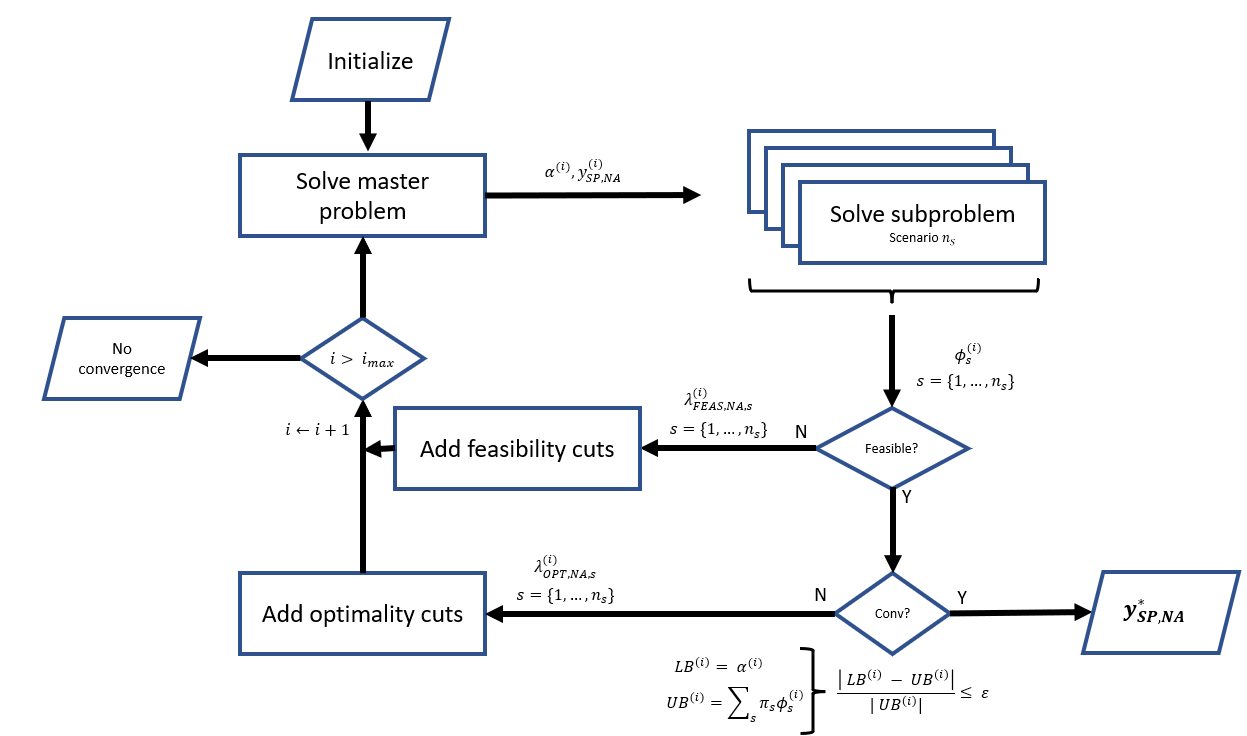
</div>

## Modeling Subproblem

In [11]:
## Modeling the sub problem (scenario) -- modeling inside a function
function subp(xInit,uInit,ysp_fixed,nReac,nScen,pScen,solNom,option)
    ###########
    # inputs: #
    ###########
    # xInit - states at the current iteration (beginning of DRTO horizon)
    # uInit - inputs at the current iteration, already implemented on the plant
    # ysp_fixed - setpoints fixed by the Master Problem --> nonanticipativity constraints
    # nReac - number of parallel reactors
    # nScen - number of scenarios used in the problem (only one branching)
    # pScen - probability of the scenarios
    # solNom - nominal solution
    # option - strategy for solving MPC 
        # for now, code only works for option = 3

    # Creating MPC matrices
    mpc = MPC_matrices(nReac)
    
    # Creating DRTO matrices
    
    # recomputing the number of total scenarios based on scenario probability and the fact that the scenarios have the same probability
    nScenTotal = ceil(Int,1/pScen)    
    drto = DRTO_matrix(nReac,nScen,nScenTotal)
    
    # Define subproblem model  #== 3
    if option == 3 || option == 1
        sub = Model(Ipopt.Optimizer)
        set_optimizer_attribute(sub, "max_cpu_time", 300.0) # 5 min
    else 
        sub = Model(CPLEX.Optimizer)
        set_optimizer_attribute(sub, "CPX_PARAM_TILIM", 300.0) # 5 min
    end
    set_silent(sub) # avoid printing
    
    ####################
    # Set up variables #
    ####################
    # DRTO model variables
    @variable(sub, xDRTO[1:pD, 1:nx])
    @variable(sub, yDRTO[1:pD])
    
    # MPC model variables
    @variable(sub, xMPC[1:pD, 1:nx])
    @variable(sub, yMPC[1:pD])

    # MPC <-> DRTO model deviation
    @variable(sub, de[1:pD])
    
    # inputs computed by MPCs
    @variable(sub, u[1:pD,1:m])
    if option == 1
        @variable(sub, u_w_c[1:pD,1:m]) # inputs w/o clipping
    
        # input clipping 
        @variable(sub, mu_lb[1:pD,1:m] ≥ 0)
        @variable(sub, eta_lb[1:pD,1:m] ≥ 0)
        @variable(sub, mu_ub[1:pD,1:m] ≥ 0)
        @variable(sub, eta_ub[1:pD,1:m] ≥ 0)       
    end
    
    # setpoints for the controllers sent to the plant (CL-DRTO degrees of freedom)
    @variable(sub, (yspMin - y0) ≤ ysp[1:pD] ≤ (yspMax - y0))
        
    # slacks for controlling setpoint into a zone
    @variable(sub, delta_p[1:pD] ≥ 0)
    
    if option == 2 || option == 3
        @variable(sub, mu_g[1:mD,1:(2*m)] ≥ 0) # upper and lower bounds for each input
    end
    if option == 2
        @variable(sub, Y_lb[1:mD,1:m], start = 0) # Relaxing binaries for big-M implementation
        @variable(sub, Y_ub[1:mD,1:m], start = 0) 
    end
    
    ########################
    # Set up initial guess #
    ########################
    if solNom isa Dict
        for ii in 1:pD
            set_start_value(yDRTO[ii], solNom['y'][ii,1]) 
            set_start_value(yMPC[ii], solNom['c'][ii,1])
            #set_start_value(ysp[ii], solNom['s'][ii,1])

            for rr in 1:nReac # when nReac increases, the number of states change!
                for xx in 1:2 # N.B. nx/reactor is hardcoded here... (maybe use nx/reactor as a function input) 
                    set_start_value(xDRTO[ii,xx + (rr - 1)*2], solNom['x'][ii,xx,1])    
                    set_start_value(xMPC[ii,xx + (rr - 1)*2], solNom['m'][ii,xx,1])           
                end # end xx
            end # number 
                
            for uu in 1:m
                set_start_value(u[ii,uu], solNom['u'][ii,uu,1])
            end # end of uu
        end # eend of ii
    end # end of if

    ######################################
    # Set up constraints and expressions #
    ######################################
    # Dynamic RTO model (linear)
    @constraint(sub, CLDRTO_dyn_model_1, xDRTO[1,:] .== drto['A']*xInit + drto['B']*uInit)
    @constraint(sub, CLDRTO_dyn_model[kk=1:(pD - 1)], xDRTO[kk + 1,:] .== drto['A']*xDRTO[kk,:] + drto['B']*u[kk,1])
    @constraint(sub, CLDRTO_model_out[kk=1:pD], yDRTO[kk] == dot(drto['C'],xDRTO[kk,:]))

    # fixing input after mD
    @constraint(sub, control_horizon[kk=(mD+1):pD], u[kk,1] == u[mD,1]);
    
    # P soft constraints
    @constraint(sub, soft_P[kk=1:pD], yDRTO[kk] - delta_p[kk] ≤ pUB)
    
    # nonanticipativity constraints
    @constraint(sub, nonAnt[kk=1:nDRTO], ysp[kk] - ysp_fixed[kk] == 0.0);
    
    ################
    # MPC solution #
    ################ 
    if option == 1
        # MPC model (linear)
        @constraint(sub, MPC_dyn_model_1, xMPC[1,:] .== mpc['A']*xInit + mpc['B']*uInit)
        @constraint(sub, MPC_dyn_model[kk=1:(pD - 1)], xMPC[kk + 1,:] .== mpc['A']*xMPC[kk,:] + mpc['B']*u_w_c[kk,1])
        @constraint(sub, MPC_model_out[kk=1:pD], yMPC[kk] == dot(mpc['C'],xMPC[kk,:]))

        #  MPC model deviation (disturance)
        @constraint(sub, MPC_model_dev[kk=1:pD], de[kk] == yDRTO[kk] - yMPC[kk])

        # sequence of Setpoints
        @expression(sub, cfT_1, (mpc['Ψ']*[xMPC[1,:];de[1]] - ysp[1:p])'*mpc['Q']*mpc['Θ'] - uInit'*mpc['I']'*mpc['R']*mpc['M'])
        @expression(sub, cfT[kk=2:mD], (mpc['Ψ']*[xMPC[kk,:];de[kk]] - ysp[kk:(kk + p - 1)])'*mpc['Q']*mpc['Θ'] - u_w_c[kk-1,1]'*mpc['I']'*mpc['R']*mpc['M'])

        # Unconstrained MPC solution  
        @constraint(sub, MPC_sol_1, mpc['H']*u_w_c[1,:] + cfT_1' .== 0)
        @constraint(sub, MPC_sol[kk=2:mD],mpc['H']*u_w_c[kk,:] + cfT[kk]' .== 0)

        # input clipping
        @constraint(sub, ic_1[kk = 1:mD,uu = 1:m], u[kk,uu] == u_w_c[kk,uu] - mu_ub[kk,uu] + mu_lb[kk,uu])
        @constraint(sub, ic_2[kk = 1:mD,uu = 1:m], (uMax - u0) - u[kk,uu] == eta_ub[kk,uu])
        @constraint(sub, ic_3[kk = 1:mD,uu = 1:m], eta_ub[kk,uu]*mu_ub[kk,uu] ≤ 1e-6)
        @constraint(sub, ic_4[kk = 1:mD,uu = 1:m], u[kk,uu] - (uMin - u0) == eta_lb[kk,uu])
        @constraint(sub, ic_5[kk = 1:mD,uu = 1:m], eta_lb[kk,uu]*mu_lb[kk,uu] ≤ 1e-6)

    
    elseif option == 2
        # MPC model (linear)
        @constraint(sub, MPC_dyn_model_1, xMPC[1,:] .== mpc['A']*xInit + mpc['B']*uInit)
        @constraint(sub, MPC_dyn_model[kk=1:(pD - 1)], xMPC[kk + 1,:] .== mpc['A']*xMPC[kk,:] + mpc['B']*u[kk,1])
        @constraint(sub, MPC_model_out[kk=1:pD], yMPC[kk] == dot(mpc['C'],xMPC[kk,:]))

        #  MPC model deviation (disturance)
        @constraint(sub, MPC_model_dev[kk=1:pD], de[kk] == yDRTO[kk] - yMPC[kk])

        # sequence of Setpoints
        @expression(sub, cfT_1, (mpc['Ψ']*[xMPC[1,:];de[1]] - ysp[1:p])'*mpc['Q']*mpc['Θ'] - uInit'*mpc['I']'*mpc['R']*mpc['M'])
        @expression(sub, cfT[kk=2:mD], (mpc['Ψ']*[xMPC[kk,:];de[kk]] - ysp[kk:(kk + p - 1)])'*mpc['Q']*mpc['Θ'] - u[kk-1,1]'*mpc['I']'*mpc['R']*mpc['M'])

        # Constrained with binaries
        # 1. stationarity
        @constraint(sub, MPC_sol_1, u[1,:]'*mpc['H'] + cfT_1 +  mu_g[1,:]'*conMatrix .== 0)
        @constraint(sub, MPC_sol[kk=2:mD], u[kk,:]'*mpc['H'] + cfT[kk] + mu_g[kk,:]'*conMatrix .== 0)

        # 2. primal feasibility
        @constraint(sub, MPC_c_upper[kk=1:mD,uu=1:m], u[kk,uu] - (uMax - u0) ≤ 0)
        @constraint(sub, MPC_c_lower[kk=1:mD,uu=1:m], (uMin - u0) - u[kk,uu] ≤ 0)
    
        # 3. complementarity --> using big-M implementation
        @constraint(sub, bigM_1[kk=1:mD,uu=1:m], mu_g[kk,uu] ≤ bigM_mu*Y_ub[kk,uu])
        @constraint(sub, bigM_2[kk=1:mD,uu=1:m], mu_g[kk,uu + m] ≤ bigM_mu*Y_lb[kk,uu])
        @constraint(sub, bigM_3[kk=1:mD,uu=1:m], u[kk,uu] - (uMax - u0) ≥ -bigM_u*(1 - Y_ub[kk,uu]))
        @constraint(sub, bigM_4[kk=1:mD,uu=1:m], (uMin - u0) - u[kk,uu] ≥ -bigM_u*(1 - Y_lb[kk,uu]))
        
        @constraint(sub, compSlack[kk=1:mD,uu=1:m], Y_ub[kk,uu] + Y_lb[kk,uu] ≤ 1)
    
    elseif option == 3
        # MPC model (linear)
        @constraint(sub, MPC_dyn_model_1, xMPC[1,:] .== mpc['A']*xInit + mpc['B']*uInit)
        @constraint(sub, MPC_dyn_model[kk=1:(pD - 1)], xMPC[kk + 1,:] .== mpc['A']*xMPC[kk,:] + mpc['B']*u[kk,1])
        @constraint(sub, MPC_model_out[kk=1:pD], yMPC[kk] == dot(mpc['C'],xMPC[kk,:]))

        #  MPC model deviation (disturance)
        @constraint(sub, MPC_model_dev[kk=1:pD], de[kk] == yDRTO[kk] - yMPC[kk])

        # sequence of Setpoints
        @expression(sub, cfT_1, (mpc['Ψ']*[xMPC[1,:];de[1]] - ysp[1:p])'*mpc['Q']*mpc['Θ'] - uInit'*mpc['I']'*mpc['R']*mpc['M'])
        @expression(sub, cfT[kk=2:mD], (mpc['Ψ']*[xMPC[kk,:];de[kk]] - ysp[kk:(kk + p - 1)])'*mpc['Q']*mpc['Θ'] - u[kk-1,1]'*mpc['I']'*mpc['R']*mpc['M'])

        # Constrained with MPCC
        # 1. stationarity
        @constraint(sub, MPC_sol_1, u[1,:]'*mpc['H'] + cfT_1 +  mu_g[1,:]'*conMatrix .== 0)
        @constraint(sub, MPC_sol[kk=2:mD], u[kk,:]'*mpc['H'] + cfT[kk] + mu_g[kk,:]'*conMatrix .== 0)

        # 2. primal feasibility       
        @constraint(sub, MPC_c_upper[kk=1:mD,uu=1:m], u[kk,uu] - (uMax - u0) ≤ 0)
        @constraint(sub, MPC_c_lower[kk=1:mD,uu=1:m], (uMin - u0) - u[kk,uu] ≤ 0)
        
        # expression to be used in OF        
        @expression(sub, g_u_u[kk=1:mD,uu=1:m], u[kk,uu] - (uMax - u0))
        @expression(sub, g_u_l[kk=1:mD,uu=1:m], (uMin - u0) - u[kk,uu])
        
    end
  
    #############################
    # Set up objective function #
    #############################
     if option == 1 || option == 2
        @objective(sub, Min, 
            pScen*sum(-yDRTO[kk] + wP*delta_p[kk]^2 for kk in 1:pD)
        )
    else
        @objective(sub, Min, 
            pScen*sum(-yDRTO[kk] + wP*delta_p[kk]^2 for kk in 1:pD)
                    - pScen*pi_bar*sum(
                                    sum(mu_g[kk,jj]*g_u_u[kk,jj] for jj = 1:m) +
                                    sum(mu_g[kk,jj + m]*g_u_l[kk,jj] for jj = 1:m)
                                for kk = 1:mD)
        )
    end
    
    # @show sub
    #set_optimizer_attribute(sub, "CPX_PARAM_BARALG", 1)
    
    optimize!(sub)
    
    # solution time
    timeSol = solve_time(sub)
    
    status = termination_status(sub)
    #display(status)
    
    # checking if there is a solution to the problem
    if status == MOI.OPTIMAL || status == MOI.ALMOST_OPTIMAL || status == MOI.LOCALLY_SOLVED
        # Proved optimality or Optimal within relaxed tolerances
        # we add an optimality cut
        flag = 1
        # #primal_status(m)

        #calling values of the solved problem
        ϕ = objective_value(sub)
        uArray = value.(u)
        yspArray = value.(ysp)
        yDRTOArray = value.(yDRTO)
        yMPCArray = value.(yMPC)
        xDRTOArray = value.(xDRTO)
        xMPCArray = value.(xMPC)
        
        # lagrange multipliers associated with the nonantecipativity constraints
        λ = dual.(nonAnt)

        outputDict = Dict('ϕ' => ϕ,
                        't' => timeSol,
                        'f' => flag, 
                        'a' => status,
                        'u' => uArray,
                        's' => yspArray,
                        'x' => xDRTOArray,
                        'y' => yDRTOArray, 
                        'm' => xMPCArray,
                        'c' => yMPCArray,
                        'λ' => λ)
        
        # if binaries are used for solving const. MPC
        if option == 2
            muArray = value.(mu_g)
                   
            uubBinArray = value.(Y_ub)
            ulbBinArray = value.(Y_lb)
            
            merge!(outputDict,Dict('μ'=> muArray))
            merge!(outputDict,Dict('o' => ulbBinArray))
            merge!(outputDict,Dict('p' => uubBinArray))
            
        end
        
        # if MPCC is used for solving const. MPC
        if option == 3
            muArray = value.(mu_g)
            
            merge!(outputDict,Dict('μ'=> muArray))
        end
        
        return outputDict
    else
        #i.e. no feasible solution --> Add feasibility cut
        #display("Feasibility cut: scenario $(scen)")        

        # ! soft bounds on ysp
        delete_lower_bound.(ysp[1:pD])
        delete_upper_bound.(ysp[1:pD])
        
        if option != 1
            # ! soft bounds on mu
            delete_lower_bound.(mu_g[1:mD,1:m])
            
            # ! soft bounds on u
            for kk in 1:mD
                for uu in 1:m
                    delete(sub, MPC_c_upper[kk,uu])
                    delete(sub, MPC_c_lower[kk,uu])
                end
            end
        end
        
        ####################
        # Set up variables #
        #################### 
        @variable(sub, delta_ysp_u[1:pD] ≥ 0.0)
        @variable(sub, delta_ysp_l[1:pD] ≥ 0.0)
        
        if option == 2 || option == 3
            @variable(sub, delta_mu[1:mD,1:m] ≥ 0.0)
            
            # slacks
            @variable(sub, delta_u_u[1:mD,1:m] ≥ 0.0)
            @variable(sub, delta_u_l[1:mD,1:m] ≥ 0.0)
        end
        
        ###########################
        # Always-feasible problem #
        ###########################                
        @constraint(sub, soft_ysp_upper[kk=1:pD], ysp[kk] - (yspMax - y0) ≤ delta_ysp_u[kk])
        @constraint(sub, soft_ysp_lower[kk=1:pD], (yspMin - y0) - ysp[kk] ≤ delta_ysp_l[kk])

        # adding a constraint to guarantee that mu is always feasible        
        if option == 2 || option == 3
            @constraint(sub, soft_MPC_mu_upper[kk=1:mD,uu=1:m], -mu_g[kk,uu] ≤ delta_mu[kk,uu])
            
            # adding a constraint to guarantee feasibility
            @constraint(sub, soft_u_upper[kk=1:mD,uu=1:m], u[kk,uu] - (uMax - u0) ≤ delta_u_u[kk,uu])
            @constraint(sub, soft_u_lower[kk=1:mD,uu=1:m], (uMin - u0) - u[kk,uu] ≤ delta_u_l[kk,uu])
        end
        
       #############################
        # Set up objective function #
        #############################
        # Modifying the objective --> call @objective with the new objective function.
        # minimizing constraint violation - l1 penalty!
        if option == 2 || option == 3
            @objective(sub, Min, sum(delta_p[kk] + delta_ysp_u[kk] + delta_ysp_l[kk] for kk in 1:pD)
                    + sum(sum(delta_mu[kk,uu] + delta_u_u[kk,uu] + delta_u_l[kk,uu] for uu in 1:m) for kk in 1:mD))
        else
            @objective(sub, Min, sum(delta_p[kk] + delta_ysp_u[kk] + delta_ysp_l[kk] for kk in 1:pD))
        end
        
        #@show sub
        #set_optimizer_attribute(sub, "CPX_PARAM_BARALG", 1)

        # re-optimizing (now using the always feasible problem)
        optimize!(sub)
        
        # solution time (adding time to solve the always feasible subproblem)
        timeSol = timeSol + solve_time(sub)
        
        # checking status of the solution
        status_sub = termination_status(sub)
        
        # flag for calling feasibility cuts (not optimality cuts)
        flag = 0
        
        #calling values of the solved problem
        uArray = value.(u)
        yspArray = value.(ysp)
        yDRTOArray = value.(yDRTO)
        yMPCArray = value.(yMPC)
        xDRTOArray = value.(xDRTO)
        xMPCArray = value.(xMPC)
    
        # objective function of the feasibility problem
        o = objective_value(sub)
        
        # lagrange multipliers associated with the nonantecipativity constraints and binaries from master problem
        λ = dual.(nonAnt)
        
        outputDict = Dict('ϕ' => o,
                        't' => timeSol,
                        'f' => flag, 
                        'a' => status_sub,
                        'u' => uArray,
                        's' => yspArray,
                        'x' => xDRTOArray,
                        'y' => yDRTOArray, 
                        'm' => xMPCArray,
                        'c' => yMPCArray,
                        'λ' => λ)
        
         if option == 2 || option == 3     
            #delta_muArray = value.(delta_mu)
            #delta_ulArray = value.(delta_u_l)
            #delta_uuArray = value.(delta_u_u)
            
            muArray = value.(mu_g)
            merge!(outputDict,Dict('μ'=> muArray))
        end
        
        return outputDict
    end
end;

Modeling Bender's Decomposition

In [12]:
# max number of iteration
benIterMax = 50

# optimality gap (relative) tolerance
optGap = 2e-3; # UNC/BIN: 0.001 | MPCC: 0.5

In [13]:
## Modeling Benders Decompostion
function BENS_CLDRTO(xInit,uInit,nReac,nScen,pScen,solNom,option)
    
    
    # flag for checking if last cut was opt. (1) or feas. (0)
    flagO = 1
    
    # timing solution via Benders
    timeSolBen = 0 
    # timing solution via parallel Benders
    timeSolParBen = 0 
    
    # Define master problem model
    master = Model(CPLEX.Optimizer)
    set_silent(master)
    
    #lower bound on scenario objective function approximation 
    alpha_down =-10.0;
    
    ####################
    # Set up variables #
    ####################
    @variable(master,  (yspMin - y0) <= ysp[1:nDRTO] <=  (yspMax - y0))     
    @variable(master, α ≥ alpha_down)
    
    ########################
    # Set up initial guess #
    ########################
    if solNom isa Dict
        for ii in 1:nDRTO
            set_start_value(ysp[ii], solNom['s'][ii,1])
        end 
    end 
 
    ################################################
    # Solving problem with benders' decomposition  #
    ################################################
    for ii in 1:benIterMax
           
        #############################
        # Set up objective function #
        #############################
        if flagO == 1 
            # last cut was an optimality cut
            # standard OF
            @objective(master, Min, α)
        else
            # last cut was a feasibility cut
            # "nudge" next solution towards nominal solution 
            @objective(master, Min, α + 0.0*sum((ysp[kk] - solNom['s'][kk,1])^2 for kk in 1:nDRTO))
        end
        
            # solve master problem (with Benders' cut)
            optimize!(master)

            # solution time
            timeSolMaster = solve_time(master)
            # Master problem solution: lower bound of the original problem
            lb = objective_value(master)
            #display(lb)

            # extracting solution for the non-anticipativity constraints
            ysp_nonⁱ = value.(ysp)
            #display(ysp_nonⁱ)

        timeSolBen = timeSolBen + timeSolMaster
        timeSolParBen = timeSolParBen + timeSolMaster # master cannot be paralellized 

        #######################
        # Solving subproblems #
        #######################
        # objective function
        o_temp = Vector{Float64}(undef,nScen)
        # flag optimality / feasibility
        flag_temp = Vector{Float64}(undef,nScen)
        # solution time
        solTime_temp = Vector{Float64}(undef,nScen)
        # multipliers
        lambdaN_temp = Matrix{Float64}(undef,nDRTO,nScen) 
        
        for ss in 1:nScen
            dicTemp = subp(xInit,uInit,ysp_nonⁱ,nReac,ss,pScen,solNom,option)
           
            # saving files
            # objective function
            o_temp[ss] = dicTemp['ϕ']
            # solution time
            solTime_temp[ss] = dicTemp['t']
            # optimality / feasibility flag
            flag_temp[ss] = dicTemp['f']
            # multiplier
            for kk in 1:nDRTO
                lambdaN_temp[kk,ss] = dicTemp['λ'][kk]
            end
            
        end
        
        ##########################################################
        # If all subproblems were feasible, check optimality gap #
        ##########################################################
        if sum(flag_temp) == nScen 
            # Subproblem solution: upper bound of the original problem
            ub = sum(o_temp)

            # solve subproblems to find the upper bound of the original problem solution 
            timeSolBen = timeSolBen + sum(solTime_temp)

            # assuming that subproblem solution is parallelized
            timeSolParBen = timeSolParBen + maximum(solTime_temp)   
            
            # compute optimality gap
            gap = abs(ub - lb)/abs(ub)
            display(" DB: opt gap = $(gap)")

            # check if optimality gap is small enough
            # also, make sure last cut was an optimality cut due to change in OF 
            if gap < optGap && flagO == 1
                global yspSol_dec = ysp_nonⁱ
                global objFun_dec = ub
                global optGap_dec = gap
                global iter_dec = ii
                global time_dec = timeSolBen
                global time_max_dec = timeSolParBen
                break
            else # gap ≥ optGap 
                ##############################
                # --> adding optimality cuts #
                ##############################
                display(">>>>>> iteration $(ii):O")
                benderscutO = @constraint(master, α ≥ ub + 
                    sum(sum(lambdaN_temp[jj,ss] for ss in 1:nScen)*(ysp[jj] - ysp_nonⁱ[jj]) for jj in 1:nDRTO))
                #@info "we are adding this bender optimality cut $(benderscutO)"
                
                # optimality cut was add
                flagO = 1
            
            end # if gap
        else # sum(flag_temp) != nScen
            ###############################
            # --> adding feasibility cuts #
            ###############################
            display(">>>>>> iteration $(ii):F")

            benderscutF = @constraint(master, 0 ≥
                sum(sum(lambdaN_temp[jj,ss] for ss in 1:nScen)*(ysp[jj] - ysp_nonⁱ[jj]) for jj in 1:nDRTO))
            #@info "we are adding this bender feasibility cut $(benderscutF)"
            
            # feasibility cut was add
            flagO = 0
            
        end # if nScen
        
        # checking if number of iterations reached max 
        if ii >= benIterMax
            global yspSol_dec = [NaN for kk=1:nDRTO]
            global objFun_dec = NaN
            global optGap_dec = NaN
            global iter_dec = benIterMax
            global time_dec = timeSolBen
            global time_max_dec = timeSolParBen
        end # if < benIterMax
    end # if for benders iterations

    #####################
    # Extracting values #
    #####################
    if isnan(objFun_dec)
        
        outputFun = Dict('t' => time_dec,
                         'ϕ' => objFun_dec,
                         'm' => time_max_dec, 
                         'i' => iter_dec,
                         'd' => yspSol_dec,
                         'g' => optGap_dec)
                        
        
        return outputFun
        
    else
        # recomputing values
        uArray = [subp(xInit,uInit,yspSol_dec,nReac,ss,pScen,solNom,option)['u']' for ss in 1:nScen]
        yArray = [subp(xInit,uInit,yspSol_dec,nReac,ss,pScen,solNom,option)['y']' for ss in 1:nScen] 
        yspArray = [subp(xInit,uInit,yspSol_dec,nReac,ss,pScen,solNom,option)['s']' for ss in 1:nScen]

        #calling values of the solved problem
        return Dict('ϕ' => objFun_dec, 
                    'd' => yspSol_dec, 
                    't' => time_dec,
                    'm' => time_max_dec, 
                    'i' => iter_dec,
                    'g' => optGap_dec,
                    'u' => uArray, 
                    'y' => yArray, 
                    's' => yspArray)
    end
     
end;

# Checking the performance of the methods in terms of time vs. nScen

In [14]:
# testing the number of scenarios
nScenMax = 50 # 30

#preparing plot 
# --> monolithic vs. decomposed 
# solution time
solTimeTraj_s = Matrix{Float64}(undef,2,nScenMax) 
# computed objective function
solObjTraj_s = Matrix{Float64}(undef,2,nScenMax) 
# --> only decomposed
# max solution time over all scenarios 
solTimeMaxTraj_s = Vector{Float64}(undef,nScenMax) 
# number of iterations
iterTraj_s = Vector{Float64}(undef,nScenMax) 
# optimality gap
optGapTraj_s = Vector{Float64}(undef,nScenMax) 

# number of reactors in parallel
nReactors = 1
# Number of states
nx = 2*nReactors

# Initial conditions (deviation form)
xInit_0 = repeat([0.3583;0.6418] .- x0, outer = [nReactors,1])
uInit_0 = 1.0 - u0;

#option = 1 --> Unconstrained MPC
#option = 2 --> Constrained MPC with binaries --> DOES NOT WORK YET!
#option = 3 --> Constrained MPC with MPCC
opti = 3
    
# Computing nominal solution #
#number of scenarios 
scenNom = 1
#equiprobable scenarios
pNom = 1.0
#number of reactors 
reacNom = 1
# number of states of the nominal solution
nx = 2*reacNom

solNominal = MS_CLDRTO(x0,u0,reacNom,scenNom,pNom,0,opti); 

for ss = 1:nScenMax
    display("evaluating $(ss) scenarios| option $(opti)")

    #number os scenarios
    nScen = ss
    #equiprobable scenarios
    pScen = 1.0/nScen
       
    # solving monolithical problem 
    sol_m_Dict = MS_CLDRTO(xInit_0,uInit_0,nReactors,nScen,pScen,solNominal,opti)

    # solving decomposed problem
    sol_d_Dict = BENS_CLDRTO(xInit_0,uInit_0,nReactors,nScen,pScen,solNominal,opti)
    
    # for plotting
    display("time M $(sol_m_Dict['t']) | time D $(sol_d_Dict['t'])")
    solTimeTraj_s[1,ss] = sol_m_Dict['t']
    solTimeTraj_s[2,ss] = sol_d_Dict['t']
    solObjTraj_s[1,ss] = sol_m_Dict['ϕ']
    solObjTraj_s[2,ss] = sol_d_Dict['ϕ']
    
    solTimeMaxTraj_s[ss] = sol_d_Dict['m']
    iterTraj_s[ss] = sol_d_Dict['i'] 
    optGapTraj_s[ss] = sol_d_Dict['g']
end



******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************



"evaluating 1 scenarios| option 3"

" DB: opt gap = 1.0375807656478298"

">>>>>> iteration 1:O"

" DB: opt gap = 0.8618685146706062"

">>>>>> iteration 2:O"

" DB: opt gap = 0.8788305651575027"

">>>>>> iteration 3:O"

" DB: opt gap = 0.9042035202197667"

">>>>>> iteration 4:O"

" DB: opt gap = 0.8695996511908609"

">>>>>> iteration 5:O"

" DB: opt gap = 0.7819219110162622"

">>>>>> iteration 6:O"

" DB: opt gap = 0.7090252050312638"

">>>>>> iteration 7:O"

" DB: opt gap = 0.6540872763956194"

">>>>>> iteration 8:O"

" DB: opt gap = 0.43706186359873017"

">>>>>> iteration 9:O"

" DB: opt gap = 0.44428971769214654"

">>>>>> iteration 10:O"

" DB: opt gap = 0.005916161868007476"

">>>>>> iteration 11:O"

" DB: opt gap = 0.005884684327507215"

">>>>>> iteration 12:O"

">>>>>> iteration 13:F"

" DB: opt gap = 0.005861765483735966"

">>>>>> iteration 14:O"

" DB: opt gap = 0.005833876496158833"

">>>>>> iteration 15:O"

" DB: opt gap = 1.9330393985728777e-8"

"time M 0.2330000400543213 | time D 3.0490005016326904"

"evaluating 2 scenarios| option 3"

" DB: opt gap = 1.0478753756044756"

">>>>>> iteration 1:O"

" DB: opt gap = 0.9272244658831643"

">>>>>> iteration 2:O"

" DB: opt gap = 0.9589143158381546"

">>>>>> iteration 3:O"

" DB: opt gap = 0.8644465957136426"

">>>>>> iteration 4:O"

" DB: opt gap = 0.9961147635779164"

">>>>>> iteration 5:O"

" DB: opt gap = 0.4935339408498277"

">>>>>> iteration 6:O"

" DB: opt gap = 0.49900984282307675"

">>>>>> iteration 7:O"

" DB: opt gap = 0.5010663709536319"

">>>>>> iteration 8:O"

" DB: opt gap = 0.5056504578033291"

">>>>>> iteration 9:O"

" DB: opt gap = 0.3228101212607733"

">>>>>> iteration 10:O"

" DB: opt gap = 0.3230273338495131"

">>>>>> iteration 11:O"

" DB: opt gap = 0.32343638634583194"

">>>>>> iteration 12:O"

" DB: opt gap = 0.0018144276923668797"

"time M 0.5870001316070557 | time D 5.508000135421753"

"evaluating 3 scenarios| option 3"

" DB: opt gap = 1.0444329169303526"

">>>>>> iteration 1:O"

" DB: opt gap = 0.9377563058753301"

">>>>>> iteration 2:O"

" DB: opt gap = 0.9600556695620251"

">>>>>> iteration 3:O"

" DB: opt gap = 0.9920506489773064"

">>>>>> iteration 4:O"

" DB: opt gap = 0.9146018365395026"

">>>>>> iteration 5:O"

" DB: opt gap = 0.9223903095411373"

">>>>>> iteration 6:O"

" DB: opt gap = 0.8457193032442221"

">>>>>> iteration 7:O"

" DB: opt gap = 0.9729088798803082"

">>>>>> iteration 8:O"

" DB: opt gap = 0.01243088600561051"

">>>>>> iteration 9:O"

" DB: opt gap = 0.01241223432686253"

">>>>>> iteration 10:O"

" DB: opt gap = 0.012305498971278838"

">>>>>> iteration 11:O"

" DB: opt gap = 0.012224979801033929"

">>>>>> iteration 12:O"

">>>>>> iteration 13:F"

" DB: opt gap = 7.93272833587542e-8"

">>>>>> iteration 14:O"

" DB: opt gap = 3.3503212091923215e-7"

"time M 0.999000072479248 | time D 8.672999858856201"

"evaluating 4 scenarios| option 3"

" DB: opt gap = 1.043487570899357"

">>>>>> iteration 1:O"

" DB: opt gap = 0.9230122684357936"

">>>>>> iteration 2:O"

" DB: opt gap = 0.9436991088508105"

">>>>>> iteration 3:O"

" DB: opt gap = 0.9776641291529529"

">>>>>> iteration 4:O"

" DB: opt gap = 0.9976684425030985"

">>>>>> iteration 5:O"

" DB: opt gap = 0.8769144899558077"

">>>>>> iteration 6:O"

" DB: opt gap = 0.8754753587688385"

">>>>>> iteration 7:O"

" DB: opt gap = 0.88122924866679"

">>>>>> iteration 8:O"

" DB: opt gap = 0.496087927407139"

">>>>>> iteration 9:O"

" DB: opt gap = 0.3400277304032658"

">>>>>> iteration 10:O"

" DB: opt gap = 0.34171825088541985"

">>>>>> iteration 11:O"

" DB: opt gap = 0.3422875396039382"

">>>>>> iteration 12:O"

" DB: opt gap = 0.34463596087567216"

">>>>>> iteration 13:O"

" DB: opt gap = 0.005030555605152826"

">>>>>> iteration 14:O"

" DB: opt gap = 0.004990065444250491"

">>>>>> iteration 15:O"

" DB: opt gap = 2.8653081082442954e-7"

"time M 1.3500001430511475 | time D 12.203999519348145"

"evaluating 5 scenarios| option 3"

" DB: opt gap = 1.0429695336127056"

">>>>>> iteration 1:O"

" DB: opt gap = 0.9448562506684128"

">>>>>> iteration 2:O"

" DB: opt gap = 0.9607113521149426"

">>>>>> iteration 3:O"

" DB: opt gap = 0.8606417154641395"

">>>>>> iteration 4:O"

" DB: opt gap = 0.9421123474529701"

">>>>>> iteration 5:O"

" DB: opt gap = 0.9890102065869323"

">>>>>> iteration 6:O"

" DB: opt gap = 0.9161221268672507"

">>>>>> iteration 7:O"

" DB: opt gap = 0.006933787972446436"

">>>>>> iteration 8:O"

" DB: opt gap = 0.0069278620905399045"

">>>>>> iteration 9:O"

" DB: opt gap = 0.006908535644705859"

">>>>>> iteration 10:O"

" DB: opt gap = 0.00690304089156178"

">>>>>> iteration 11:O"

" DB: opt gap = 0.006864553161589513"

">>>>>> iteration 12:O"

" DB: opt gap = 0.006858910810898448"

">>>>>> iteration 13:O"

">>>>>> iteration 14:F"

" DB: opt gap = 0.006824891974684965"

">>>>>> iteration 15:O"

" DB: opt gap = 0.006842684854299829"

">>>>>> iteration 16:O"

" DB: opt gap = 0.006817040593918741"

">>>>>> iteration 17:O"

" DB: opt gap = 0.00679836009490053"

">>>>>> iteration 18:O"

" DB: opt gap = 0.006790964923113901"

">>>>>> iteration 19:O"

" DB: opt gap = 2.61897712000198e-7"

"time M 1.312000036239624 | time D 19.376999855041504"

"evaluating 6 scenarios| option 3"

" DB: opt gap = 1.042760601708332"

">>>>>> iteration 1:O"

" DB: opt gap = 0.922392308574493"

">>>>>> iteration 2:O"

" DB: opt gap = 0.9458241846056404"

">>>>>> iteration 3:O"

" DB: opt gap = 0.9900291242217344"

">>>>>> iteration 4:O"

" DB: opt gap = 0.883196285116832"

">>>>>> iteration 5:O"

" DB: opt gap = 0.9128771859317286"

">>>>>> iteration 6:O"

" DB: opt gap = 0.8348784079567849"

">>>>>> iteration 7:O"

" DB: opt gap = 0.7927708395820741"

">>>>>> iteration 8:O"

" DB: opt gap = 0.8265842136803901"

">>>>>> iteration 9:O"

" DB: opt gap = 0.6304458396568856"

">>>>>> iteration 10:O"

" DB: opt gap = 0.6526856029956692"

">>>>>> iteration 11:O"

" DB: opt gap = 0.007363762546084572"

">>>>>> iteration 12:O"

" DB: opt gap = 0.00735590523374916"

">>>>>> iteration 13:O"

" DB: opt gap = 0.007336680029371127"

">>>>>> iteration 14:O"

">>>>>> iteration 15:F"

" DB: opt gap = 3.126611056223462e-8"

">>>>>> iteration 16:O"

" DB: opt gap = 1.0040230243983207e-7"

"time M 2.2029998302459717 | time D 18.969000339508057"

"evaluating 7 scenarios| option 3"

" DB: opt gap = 1.0424158672696786"

">>>>>> iteration 1:O"

" DB: opt gap = 0.9162781512917132"

">>>>>> iteration 2:O"

" DB: opt gap = 0.94538030340426"

">>>>>> iteration 3:O"

" DB: opt gap = 0.8834744616276167"

">>>>>> iteration 4:O"

" DB: opt gap = 0.8358117148145507"

">>>>>> iteration 5:O"

" DB: opt gap = 0.8486195869200613"

">>>>>> iteration 6:O"

" DB: opt gap = 0.8395989363312185"

">>>>>> iteration 7:O"

" DB: opt gap = 0.8845343326296087"

">>>>>> iteration 8:O"

" DB: opt gap = 0.8704984125247006"

">>>>>> iteration 9:O"

" DB: opt gap = 0.6420348698278864"

">>>>>> iteration 10:O"

" DB: opt gap = 0.6532057484518995"

">>>>>> iteration 11:O"

" DB: opt gap = 0.00574497445083305"

">>>>>> iteration 12:O"

" DB: opt gap = 0.005710854376029723"

">>>>>> iteration 13:O"

" DB: opt gap = 0.0057055446053866496"

">>>>>> iteration 14:O"

" DB: opt gap = 2.242660482080506e-8"

"time M 3.6630001068115234 | time D 20.16800022125244"

"evaluating 8 scenarios| option 3"

" DB: opt gap = 1.0423501506283062"

">>>>>> iteration 1:O"

" DB: opt gap = 0.9323244873272359"

">>>>>> iteration 2:O"

" DB: opt gap = 0.9560325145182664"

">>>>>> iteration 3:O"

" DB: opt gap = 0.9923741726127261"

">>>>>> iteration 4:O"

" DB: opt gap = 0.9018091940387332"

">>>>>> iteration 5:O"

" DB: opt gap = 0.8923915391496178"

">>>>>> iteration 6:O"

" DB: opt gap = 0.9198742882154403"

">>>>>> iteration 7:O"

" DB: opt gap = 0.8359481094274205"

">>>>>> iteration 8:O"

" DB: opt gap = 0.9893860326958712"

">>>>>> iteration 9:O"

" DB: opt gap = 0.911293655344974"

">>>>>> iteration 10:O"

" DB: opt gap = 0.691965686266319"

">>>>>> iteration 11:O"

" DB: opt gap = 0.7103311737593196"

">>>>>> iteration 12:O"

" DB: opt gap = 0.004837210797151336"

">>>>>> iteration 13:O"

" DB: opt gap = 0.004833387785188703"

">>>>>> iteration 14:O"

" DB: opt gap = 0.0048115350449686855"

">>>>>> iteration 15:O"

">>>>>> iteration 16:F"

" DB: opt gap = 1.273766323257562e-7"

">>>>>> iteration 17:O"

" DB: opt gap = 1.2518344100877322e-7"

"time M 3.947000026702881 | time D 26.922999620437622"

"evaluating 9 scenarios| option 3"

" DB: opt gap = 1.0422317847010467"

">>>>>> iteration 1:O"

" DB: opt gap = 0.9267290204259595"

">>>>>> iteration 2:O"

" DB: opt gap = 0.9516528222281045"

">>>>>> iteration 3:O"

" DB: opt gap = 0.9767948344305457"

">>>>>> iteration 4:O"

" DB: opt gap = 1.016032487455961"

">>>>>> iteration 5:O"

" DB: opt gap = 0.939161589021756"

">>>>>> iteration 6:O"

" DB: opt gap = 0.8509676595687639"

">>>>>> iteration 7:O"

" DB: opt gap = 0.8263754607812748"

">>>>>> iteration 8:O"

" DB: opt gap = 0.9589195391679313"

">>>>>> iteration 9:O"

" DB: opt gap = 0.012572615056447961"

">>>>>> iteration 10:O"

" DB: opt gap = 0.012556853430387371"

">>>>>> iteration 11:O"

">>>>>> iteration 12:F"

" DB: opt gap = 0.012512505378947771"

">>>>>> iteration 13:O"

" DB: opt gap = 0.012470084379892544"

">>>>>> iteration 14:O"

" DB: opt gap = 0.012211786298485032"

">>>>>> iteration 15:O"

" DB: opt gap = 0.01176501624631263"

">>>>>> iteration 16:O"

" DB: opt gap = 6.09224683909575e-6"

"time M 5.664999961853027 | time D 27.06600069999695"

"evaluating 10 scenarios| option 3"

" DB: opt gap = 1.0418767297503297"

">>>>>> iteration 1:O"

" DB: opt gap = 0.9372933794515944"

">>>>>> iteration 2:O"

" DB: opt gap = 0.9595369686780192"

">>>>>> iteration 3:O"

" DB: opt gap = 0.8765923453196676"

">>>>>> iteration 4:O"

" DB: opt gap = 0.9919866303352577"

">>>>>> iteration 5:O"

" DB: opt gap = 0.8759390365139792"

">>>>>> iteration 6:O"

" DB: opt gap = 0.8651786088861172"

">>>>>> iteration 7:O"

" DB: opt gap = 0.9004274757817989"

">>>>>> iteration 8:O"

" DB: opt gap = 0.7383240549359822"

">>>>>> iteration 9:O"

" DB: opt gap = 0.7505122763977735"

">>>>>> iteration 10:O"

" DB: opt gap = 0.761445728386234"

">>>>>> iteration 11:O"

" DB: opt gap = 0.7826992652835262"

">>>>>> iteration 12:O"

" DB: opt gap = 0.6293959220676586"

">>>>>> iteration 13:O"

" DB: opt gap = 0.005389585312797081"

">>>>>> iteration 14:O"

" DB: opt gap = 0.005385128001421057"

">>>>>> iteration 15:O"

" DB: opt gap = 0.005344636538815029"

">>>>>> iteration 16:O"

" DB: opt gap = 0.005346023538376725"

">>>>>> iteration 17:O"

">>>>>> iteration 18:F"

" DB: opt gap = 0.005316890162658612"

">>>>>> iteration 19:O"

" DB: opt gap = 0.0053051435111413706"

">>>>>> iteration 20:O"

" DB: opt gap = 0.005300936073382915"

">>>>>> iteration 21:O"

" DB: opt gap = 0.005217033806215134"

">>>>>> iteration 22:O"

" DB: opt gap = 0.004913248835279383"

">>>>>> iteration 23:O"

" DB: opt gap = 0.00490804277836195"

">>>>>> iteration 24:O"

" DB: opt gap = 4.9713767772860645e-6"

"time M 6.117000102996826 | time D 49.00600004196167"

"evaluating 11 scenarios| option 3"

" DB: opt gap = 1.0421321310586302"

">>>>>> iteration 1:O"

" DB: opt gap = 0.9108937316549401"

">>>>>> iteration 2:O"

" DB: opt gap = 0.9402499997098741"

">>>>>> iteration 3:O"

" DB: opt gap = 0.9418782016075941"

">>>>>> iteration 4:O"

" DB: opt gap = 0.7831647295558215"

">>>>>> iteration 5:O"

" DB: opt gap = 0.7891470197184617"

">>>>>> iteration 6:O"

" DB: opt gap = 0.8069377111783758"

">>>>>> iteration 7:O"

" DB: opt gap = 0.8210282113843239"

">>>>>> iteration 8:O"

" DB: opt gap = 0.39692407056998164"

">>>>>> iteration 9:O"

" DB: opt gap = 0.39750308395666667"

">>>>>> iteration 10:O"

" DB: opt gap = 0.3992450120868475"

">>>>>> iteration 11:O"

" DB: opt gap = 0.4000304069006979"

">>>>>> iteration 12:O"

" DB: opt gap = 0.40347048092900795"

">>>>>> iteration 13:O"

" DB: opt gap = 0.404507376655387"

">>>>>> iteration 14:O"

" DB: opt gap = 0.004971383367531919"

">>>>>> iteration 15:O"

" DB: opt gap = 0.004955971232947659"

">>>>>> iteration 16:O"

" DB: opt gap = 2.7655188641281854e-8"

"time M 6.457000017166138 | time D 37.24700045585632"

"evaluating 12 scenarios| option 3"

" DB: opt gap = 1.0417350594973187"

">>>>>> iteration 1:O"

" DB: opt gap = 0.9348471244971092"

">>>>>> iteration 2:O"

" DB: opt gap = 0.95266353276528"

">>>>>> iteration 3:O"

" DB: opt gap = 0.8644910361638086"

">>>>>> iteration 4:O"

" DB: opt gap = 0.9913181712891651"

">>>>>> iteration 5:O"

" DB: opt gap = 0.8823895193366406"

">>>>>> iteration 6:O"

" DB: opt gap = 0.9741515981043571"

">>>>>> iteration 7:O"

" DB: opt gap = 0.8072328581643446"

">>>>>> iteration 8:O"

" DB: opt gap = 0.8378383780285075"

">>>>>> iteration 9:O"

" DB: opt gap = 0.01220254719107734"

">>>>>> iteration 10:O"

" DB: opt gap = 0.012189438939741936"

">>>>>> iteration 11:O"

" DB: opt gap = 0.0121460946777474"

">>>>>> iteration 12:O"

" DB: opt gap = 0.012131452574374941"

">>>>>> iteration 13:O"

" DB: opt gap = 6.333742540685307e-7"

"time M 5.700000047683716 | time D 32.15899991989136"

"evaluating 13 scenarios| option 3"

" DB: opt gap = 1.0419214460056543"

">>>>>> iteration 1:O"

" DB: opt gap = 0.936805686228094"

">>>>>> iteration 2:O"

" DB: opt gap = 0.9605112636959088"

">>>>>> iteration 3:O"

" DB: opt gap = 0.860646802433179"

">>>>>> iteration 4:O"

" DB: opt gap = 0.924505656193883"

">>>>>> iteration 5:O"

" DB: opt gap = 0.9746524610784081"

">>>>>> iteration 6:O"

" DB: opt gap = 0.9096877140118991"

">>>>>> iteration 7:O"

" DB: opt gap = 0.006356982213797828"

">>>>>> iteration 8:O"

" DB: opt gap = 0.006351755765232058"

">>>>>> iteration 9:O"

">>>>>> iteration 10:F"

" DB: opt gap = 0.006337155650636967"

">>>>>> iteration 11:O"

" DB: opt gap = 0.006328772779039435"

">>>>>> iteration 12:O"

" DB: opt gap = 0.006286382445913338"

">>>>>> iteration 13:O"

" DB: opt gap = 0.006210303356418707"

">>>>>> iteration 14:O"

" DB: opt gap = 0.006175490718753802"

">>>>>> iteration 15:O"

" DB: opt gap = 0.00614493885300695"

">>>>>> iteration 16:O"

" DB: opt gap = 5.863764282249796e-7"

"time M 6.549999952316284 | time D 41.96500086784363"

"evaluating 14 scenarios| option 3"

" DB: opt gap = 1.0419383312264685"

">>>>>> iteration 1:O"

" DB: opt gap = 0.9101760170062366"

">>>>>> iteration 2:O"

" DB: opt gap = 0.9387653059854892"

">>>>>> iteration 3:O"

" DB: opt gap = 0.9395348046430717"

">>>>>> iteration 4:O"

" DB: opt gap = 0.8593339677732871"

">>>>>> iteration 5:O"

" DB: opt gap = 0.8231016339924716"

">>>>>> iteration 6:O"

" DB: opt gap = 0.9045154614828667"

">>>>>> iteration 7:O"

" DB: opt gap = 0.006241230033940351"

">>>>>> iteration 8:O"

" DB: opt gap = 0.006234458549219087"

">>>>>> iteration 9:O"

">>>>>> iteration 10:F"

" DB: opt gap = 0.006215735241382462"

">>>>>> iteration 11:O"

" DB: opt gap = 0.006194753664458305"

">>>>>> iteration 12:O"

" DB: opt gap = 0.0061601649008948866"

">>>>>> iteration 13:O"

" DB: opt gap = 0.0061413918788518285"

">>>>>> iteration 14:O"

" DB: opt gap = 5.014937779054605e-7"

"time M 9.244999885559082 | time D 39.16500115394592"

"evaluating 15 scenarios| option 3"

" DB: opt gap = 1.0418590733711357"

">>>>>> iteration 1:O"

" DB: opt gap = 0.9299678894403521"

">>>>>> iteration 2:O"

" DB: opt gap = 0.9551255189270164"

">>>>>> iteration 3:O"

" DB: opt gap = 0.8673253114414029"

">>>>>> iteration 4:O"

" DB: opt gap = 0.9928217173344303"

">>>>>> iteration 5:O"

" DB: opt gap = 0.889289864601255"

">>>>>> iteration 6:O"

" DB: opt gap = 0.9100575193123824"

">>>>>> iteration 7:O"

" DB: opt gap = 0.8530626743370516"

">>>>>> iteration 8:O"

" DB: opt gap = 0.8717662778212659"

">>>>>> iteration 9:O"

" DB: opt gap = 0.8192958193308437"

">>>>>> iteration 10:O"

" DB: opt gap = 0.9105527977639719"

">>>>>> iteration 11:O"

" DB: opt gap = 0.9386118658310164"

">>>>>> iteration 12:O"

" DB: opt gap = 0.8666652343958393"

">>>>>> iteration 13:O"

" DB: opt gap = 0.012289679816773258"

">>>>>> iteration 14:O"

" DB: opt gap = 0.012236235182029747"

">>>>>> iteration 15:O"

" DB: opt gap = 0.012161291844411871"

">>>>>> iteration 16:O"

" DB: opt gap = 0.012083775621373404"

">>>>>> iteration 17:O"

">>>>>> iteration 18:F"

" DB: opt gap = 2.8331357740086794e-7"

">>>>>> iteration 19:O"

" DB: opt gap = 3.4244657574302023e-7"

"time M 8.79699993133545 | time D 58.90700125694275"

"evaluating 16 scenarios| option 3"

" DB: opt gap = 1.0418282964990337"

">>>>>> iteration 1:O"

" DB: opt gap = 0.9215305127234599"

">>>>>> iteration 2:O"

" DB: opt gap = 0.950927956539077"

">>>>>> iteration 3:O"

" DB: opt gap = 0.9909601494092021"

">>>>>> iteration 4:O"

" DB: opt gap = 0.8973303538615861"

">>>>>> iteration 5:O"

" DB: opt gap = 0.9210125414610343"

">>>>>> iteration 6:O"

" DB: opt gap = 0.9129933070187135"

">>>>>> iteration 7:O"

" DB: opt gap = 0.8411999531749709"

">>>>>> iteration 8:O"

" DB: opt gap = 0.916713032083713"

">>>>>> iteration 9:O"

" DB: opt gap = 0.7665789652250978"

">>>>>> iteration 10:O"

" DB: opt gap = 0.005771314709397159"

">>>>>> iteration 11:O"

" DB: opt gap = 0.005752881648089472"

">>>>>> iteration 12:O"

" DB: opt gap = 0.005727494993254731"

">>>>>> iteration 13:O"

">>>>>> iteration 14:F"

" DB: opt gap = 0.005696569407570964"

">>>>>> iteration 15:O"

" DB: opt gap = 0.005702716002012747"

">>>>>> iteration 16:O"

" DB: opt gap = 2.2211950922614023e-8"

"time M 10.187000036239624 | time D 52.79400062561035"

"evaluating 17 scenarios| option 3"

" DB: opt gap = 1.041837115363429"

">>>>>> iteration 1:O"

" DB: opt gap = 0.9187968694003879"

">>>>>> iteration 2:O"

" DB: opt gap = 0.945677804924225"

">>>>>> iteration 3:O"

" DB: opt gap = 0.9735058846541391"

">>>>>> iteration 4:O"

" DB: opt gap = 0.997040745316219"

">>>>>> iteration 5:O"

" DB: opt gap = 0.01618703891864384"

">>>>>> iteration 6:O"

" DB: opt gap = 0.016165122358863537"

">>>>>> iteration 7:O"

">>>>>> iteration 8:F"

" DB: opt gap = 0.016103289008032866"

">>>>>> iteration 9:O"

" DB: opt gap = 0.01607996243442615"

">>>>>> iteration 10:O"

" DB: opt gap = 0.015638154800081874"

">>>>>> iteration 11:O"

" DB: opt gap = 0.015684353973551786"

">>>>>> iteration 12:O"

" DB: opt gap = 0.015568157904933268"

">>>>>> iteration 13:O"

" DB: opt gap = 1.7968161141022971e-6"

"time M 13.103000164031982 | time D 45.125001192092896"

"evaluating 18 scenarios| option 3"

" DB: opt gap = 1.0418402889886895"

">>>>>> iteration 1:O"

" DB: opt gap = 0.9387366601509074"

">>>>>> iteration 2:O"

" DB: opt gap = 0.9652204903409631"

">>>>>> iteration 3:O"

" DB: opt gap = 0.9960045963593684"

">>>>>> iteration 4:O"

" DB: opt gap = 0.8933175136413399"

">>>>>> iteration 5:O"

" DB: opt gap = 0.9167343464960815"

">>>>>> iteration 6:O"

" DB: opt gap = 0.8395118018878093"

">>>>>> iteration 7:O"

" DB: opt gap = 0.9987813401167536"

">>>>>> iteration 8:O"

" DB: opt gap = 0.8387557553253392"

">>>>>> iteration 9:O"

" DB: opt gap = 0.9161760039662236"

">>>>>> iteration 10:O"

" DB: opt gap = 0.005912354838641243"

">>>>>> iteration 11:O"

" DB: opt gap = 0.005892970250384374"

">>>>>> iteration 12:O"

" DB: opt gap = 0.005871801124699729"

">>>>>> iteration 13:O"

">>>>>> iteration 14:F"

" DB: opt gap = 0.005834589067071226"

">>>>>> iteration 15:O"

" DB: opt gap = 0.00584365925662506"

">>>>>> iteration 16:O"

">>>>>> iteration 17:F"

">>>>>> iteration 18:F"

">>>>>> iteration 19:F"

">>>>>> iteration 20:F"

">>>>>> iteration 21:F"

">>>>>> iteration 22:F"

">>>>>> iteration 23:F"

">>>>>> iteration 24:F"

">>>>>> iteration 25:F"

">>>>>> iteration 26:F"

">>>>>> iteration 27:F"

">>>>>> iteration 28:F"

">>>>>> iteration 29:F"

">>>>>> iteration 30:F"

">>>>>> iteration 31:F"

">>>>>> iteration 32:F"

">>>>>> iteration 33:F"

">>>>>> iteration 34:F"

">>>>>> iteration 35:F"

">>>>>> iteration 36:F"

">>>>>> iteration 37:F"

">>>>>> iteration 38:F"

">>>>>> iteration 39:F"

">>>>>> iteration 40:F"

">>>>>> iteration 41:F"

">>>>>> iteration 42:F"

">>>>>> iteration 43:F"

">>>>>> iteration 44:F"

">>>>>> iteration 45:F"

">>>>>> iteration 46:F"

">>>>>> iteration 47:F"

">>>>>> iteration 48:F"

">>>>>> iteration 49:F"

">>>>>> iteration 50:F"

"time M 14.717000007629395 | time D 56.71300005912781"

"evaluating 19 scenarios| option 3"

" DB: opt gap = 1.0416539957466093"

">>>>>> iteration 1:O"

" DB: opt gap = 0.9149835119969683"

">>>>>> iteration 2:O"

" DB: opt gap = 0.943830962980111"

">>>>>> iteration 3:O"

" DB: opt gap = 0.8812944544718179"

">>>>>> iteration 4:O"

" DB: opt gap = 0.826993805176167"

">>>>>> iteration 5:O"

" DB: opt gap = 0.9055628151476347"

">>>>>> iteration 6:O"

" DB: opt gap = 0.842580023000582"

">>>>>> iteration 7:O"

" DB: opt gap = 0.868043272132744"

">>>>>> iteration 8:O"

" DB: opt gap = 1.007028311182781"

">>>>>> iteration 9:O"

" DB: opt gap = 0.01653345355357355"

">>>>>> iteration 10:O"

" DB: opt gap = 0.01651272909072815"

">>>>>> iteration 11:O"

" DB: opt gap = 0.01645641607848855"

">>>>>> iteration 12:O"

">>>>>> iteration 13:F"

" DB: opt gap = 0.0163508540719146"

">>>>>> iteration 14:O"

" DB: opt gap = 0.016045978176092393"

">>>>>> iteration 15:O"

" DB: opt gap = 0.014965665936619167"

">>>>>> iteration 16:O"

" DB: opt gap = 4.337522536861242e-5"

"time M 12.49400019645691 | time D 62.45899963378906"

"evaluating 20 scenarios| option 3"

" DB: opt gap = 1.0417799725613197"

">>>>>> iteration 1:O"

" DB: opt gap = 0.940479939605595"

">>>>>> iteration 2:O"

" DB: opt gap = 0.9526632667464247"

">>>>>> iteration 3:O"

" DB: opt gap = 0.8546102065139672"

">>>>>> iteration 4:O"

" DB: opt gap = 0.9185756116400962"

">>>>>> iteration 5:O"

" DB: opt gap = 0.9761866974743414"

">>>>>> iteration 6:O"

" DB: opt gap = 0.014900300280127942"

">>>>>> iteration 7:O"

" DB: opt gap = 0.014883742201014741"

">>>>>> iteration 8:O"

" DB: opt gap = 0.014829577615778806"

">>>>>> iteration 9:O"

" DB: opt gap = 0.014809752146140016"

">>>>>> iteration 10:O"

" DB: opt gap = 0.014730350302427574"

">>>>>> iteration 11:O"

" DB: opt gap = 0.01458178404302455"

">>>>>> iteration 12:O"

">>>>>> iteration 13:F"

" DB: opt gap = 0.014652237870377241"

">>>>>> iteration 14:O"

" DB: opt gap = 0.014452230241081205"

">>>>>> iteration 15:O"

" DB: opt gap = 0.014426889801525474"

">>>>>> iteration 16:O"

" DB: opt gap = 1.4483388567371784e-6"

"time M 14.730999946594238 | time D 67.28499937057495"

"evaluating 21 scenarios| option 3"

" DB: opt gap = 1.0418278355738175"

">>>>>> iteration 1:O"

" DB: opt gap = 0.919318226928353"

">>>>>> iteration 2:O"

" DB: opt gap = 0.9469338411015299"

">>>>>> iteration 3:O"

" DB: opt gap = 0.9866191483805791"

">>>>>> iteration 4:O"

" DB: opt gap = 1.0166663753732248"

">>>>>> iteration 5:O"

" DB: opt gap = 0.9210639641188125"

">>>>>> iteration 6:O"

" DB: opt gap = 0.8456071025125099"

">>>>>> iteration 7:O"

" DB: opt gap = 0.001433378006142558"

"time M 17.74399995803833 | time D 33.257000207901"

"evaluating 22 scenarios| option 3"

" DB: opt gap = 1.0417295307868322"

">>>>>> iteration 1:O"

" DB: opt gap = 0.9254204668313514"

">>>>>> iteration 2:O"

" DB: opt gap = 0.9533722882491417"

">>>>>> iteration 3:O"

" DB: opt gap = 0.9932518342177644"

">>>>>> iteration 4:O"

" DB: opt gap = 1.0212045548548216"

">>>>>> iteration 5:O"

" DB: opt gap = 0.9248668049343972"

">>>>>> iteration 6:O"

" DB: opt gap = 0.8393650100421411"

">>>>>> iteration 7:O"

" DB: opt gap = 0.9358446646983593"

">>>>>> iteration 8:O"

" DB: opt gap = 0.007362014801245644"

">>>>>> iteration 9:O"

" DB: opt gap = 0.007354028379874961"

">>>>>> iteration 10:O"

" DB: opt gap = 0.007334619877068002"

">>>>>> iteration 11:O"

" DB: opt gap = 0.0072868508903140864"

">>>>>> iteration 12:O"

" DB: opt gap = 0.007279461820127855"

">>>>>> iteration 13:O"

" DB: opt gap = 0.007231761519286398"

">>>>>> iteration 14:O"

" DB: opt gap = 0.007253194588495674"

">>>>>> iteration 15:O"

" DB: opt gap = 0.007223934793673794"

">>>>>> iteration 16:O"

" DB: opt gap = 0.007245401794637229"

">>>>>> iteration 17:O"

">>>>>> iteration 18:F"

" DB: opt gap = 9.551819961466729e-8"

">>>>>> iteration 19:O"

" DB: opt gap = 5.494904535831968e-8"

"time M 10.542999982833862 | time D 85.40899801254272"

"evaluating 23 scenarios| option 3"

" DB: opt gap = 1.0415887151134335"

">>>>>> iteration 1:O"

" DB: opt gap = 0.9232577930654688"

">>>>>> iteration 2:O"

" DB: opt gap = 0.9516461130794522"

">>>>>> iteration 3:O"

" DB: opt gap = 0.9835508955049156"

">>>>>> iteration 4:O"

" DB: opt gap = 1.010530056635477"

">>>>>> iteration 5:O"

" DB: opt gap = 0.017012367406717355"

">>>>>> iteration 6:O"

" DB: opt gap = 0.01699206012489203"

">>>>>> iteration 7:O"

" DB: opt gap = 0.016923747425631984"

">>>>>> iteration 8:O"

" DB: opt gap = 0.016900044768364396"

">>>>>> iteration 9:O"

">>>>>> iteration 10:F"

" DB: opt gap = 0.016808454155836317"

">>>>>> iteration 11:O"

" DB: opt gap = 0.01672919912612284"

">>>>>> iteration 12:O"

" DB: opt gap = 0.016577264835089235"

">>>>>> iteration 13:O"

" DB: opt gap = 8.195493907322576e-7"

"time M 17.16099977493286 | time D 60.79899883270264"

"evaluating 24 scenarios| option 3"

" DB: opt gap = 1.0417293378682153"

">>>>>> iteration 1:O"

" DB: opt gap = 0.9285380894933779"

">>>>>> iteration 2:O"

" DB: opt gap = 0.9583350450655073"

">>>>>> iteration 3:O"

" DB: opt gap = 0.8711994797919935"

">>>>>> iteration 4:O"

" DB: opt gap = 0.9945925333405764"

">>>>>> iteration 5:O"

" DB: opt gap = 0.9051997268379856"

">>>>>> iteration 6:O"

" DB: opt gap = 0.8961139400752457"

">>>>>> iteration 7:O"

" DB: opt gap = 0.81458908617364"

">>>>>> iteration 8:O"

" DB: opt gap = 0.8947958015141096"

">>>>>> iteration 9:O"

" DB: opt gap = 0.8467940370967953"

">>>>>> iteration 10:O"

" DB: opt gap = 0.859515356104545"

">>>>>> iteration 11:O"

">>>>>> iteration 12:F"

" DB: opt gap = 0.8911173907810019"

">>>>>> iteration 13:O"

" DB: opt gap = 0.6480203204566589"

">>>>>> iteration 14:O"

" DB: opt gap = 0.48910979708561075"

">>>>>> iteration 15:O"

" DB: opt gap = 0.002933216887039985"

">>>>>> iteration 16:O"

" DB: opt gap = 0.0029243605995497753"

">>>>>> iteration 17:O"

" DB: opt gap = 0.002866830884821715"

">>>>>> iteration 18:O"

" DB: opt gap = 0.0028643147563464683"

">>>>>> iteration 19:O"

" DB: opt gap = 0.0028560059836574554"

">>>>>> iteration 20:O"

" DB: opt gap = 0.0028603110659329773"

">>>>>> iteration 21:O"

" DB: opt gap = 0.002846561717653334"

">>>>>> iteration 22:O"

" DB: opt gap = 0.0028445886512055768"

">>>>>> iteration 23:O"

" DB: opt gap = 2.7377531764819616e-7"

"time M 16.53600001335144 | time D 114.55399894714355"

"evaluating 25 scenarios| option 3"

" DB: opt gap = 1.041677391007867"

">>>>>> iteration 1:O"

" DB: opt gap = 0.9364464035904863"

">>>>>> iteration 2:O"

" DB: opt gap = 0.9597579760539746"

">>>>>> iteration 3:O"

" DB: opt gap = 0.8656516090257552"

">>>>>> iteration 4:O"

" DB: opt gap = 0.9711983214904869"

">>>>>> iteration 5:O"

" DB: opt gap = 1.0043178373043395"

">>>>>> iteration 6:O"

">>>>>> iteration 7:F"

" DB: opt gap = 0.8080387307360669"

">>>>>> iteration 8:O"

" DB: opt gap = 0.889458923949448"

">>>>>> iteration 9:O"

" DB: opt gap = 0.005195468160384344"

">>>>>> iteration 10:O"

" DB: opt gap = 0.005123097314627443"

">>>>>> iteration 11:O"

" DB: opt gap = 0.005090715763016709"

">>>>>> iteration 12:O"

" DB: opt gap = 0.004520344009743268"

">>>>>> iteration 13:O"

" DB: opt gap = 0.004462567890645803"

">>>>>> iteration 14:O"

" DB: opt gap = 0.004405383998951017"

">>>>>> iteration 15:O"

" DB: opt gap = 0.0043653302537147946"

">>>>>> iteration 16:O"

" DB: opt gap = 2.0185925385078313e-5"

"time M 17.743000030517578 | time D 80.05000233650208"

"evaluating 26 scenarios| option 3"

" DB: opt gap = 1.0417709250620022"

">>>>>> iteration 1:O"

" DB: opt gap = 0.9408481563247661"

">>>>>> iteration 2:O"

" DB: opt gap = 0.9647792520775199"

">>>>>> iteration 3:O"

" DB: opt gap = 0.9951051427114669"

">>>>>> iteration 4:O"

" DB: opt gap = 0.9007866764561008"

">>>>>> iteration 5:O"

" DB: opt gap = 0.9236346381284678"

">>>>>> iteration 6:O"

" DB: opt gap = 0.8494444587918867"

">>>>>> iteration 7:O"

" DB: opt gap = 1.0263525931471587"

">>>>>> iteration 8:O"

" DB: opt gap = 0.9111489720741405"

">>>>>> iteration 9:O"

" DB: opt gap = 0.9359032104988785"

">>>>>> iteration 10:O"

" DB: opt gap = 0.007364190796143439"

">>>>>> iteration 11:O"

" DB: opt gap = 0.0073576017840929165"

">>>>>> iteration 12:O"

" DB: opt gap = 0.007338843052539833"

">>>>>> iteration 13:O"

" DB: opt gap = 0.007332995951412576"

">>>>>> iteration 14:O"

" DB: opt gap = 0.007309460426126954"

">>>>>> iteration 15:O"

" DB: opt gap = 0.007302478945022811"

">>>>>> iteration 16:O"

" DB: opt gap = 0.007245347405420784"

">>>>>> iteration 17:O"

" DB: opt gap = 0.007239459752048207"

">>>>>> iteration 18:O"

" DB: opt gap = 0.0072178623008872875"

">>>>>> iteration 19:O"

" DB: opt gap = 0.007211034953051702"

">>>>>> iteration 20:O"

" DB: opt gap = 0.007187312738148353"

">>>>>> iteration 21:O"

">>>>>> iteration 22:F"

" DB: opt gap = 3.5122975001937444e-7"

">>>>>> iteration 23:O"

" DB: opt gap = 5.024006405073435e-7"

"time M 25.579999923706055 | time D 127.57199907302856"

"evaluating 27 scenarios| option 3"

" DB: opt gap = 1.04170493766051"

">>>>>> iteration 1:O"

" DB: opt gap = 0.9339302673015119"

">>>>>> iteration 2:O"

" DB: opt gap = 0.958869476991273"

">>>>>> iteration 3:O"

" DB: opt gap = 0.9926540644068897"

">>>>>> iteration 4:O"

" DB: opt gap = 0.9052595292078505"

">>>>>> iteration 5:O"

" DB: opt gap = 0.9248925920367131"

">>>>>> iteration 6:O"

" DB: opt gap = 0.8533521760668537"

">>>>>> iteration 7:O"

" DB: opt gap = 1.0206148453267792"

">>>>>> iteration 8:O"

" DB: opt gap = 0.9187007349035501"

">>>>>> iteration 9:O"

" DB: opt gap = 0.005950109717078825"

">>>>>> iteration 10:O"

" DB: opt gap = 0.005945437552676484"

">>>>>> iteration 11:O"

" DB: opt gap = 0.005931491988560982"

">>>>>> iteration 12:O"

" DB: opt gap = 0.0059262282732697475"

">>>>>> iteration 13:O"

">>>>>> iteration 14:F"

" DB: opt gap = 0.0059077602371755"

">>>>>> iteration 15:O"

" DB: opt gap = 0.005889437129984775"

">>>>>> iteration 16:O"

" DB: opt gap = 0.0058489051848211815"

">>>>>> iteration 17:O"

" DB: opt gap = 0.005838095828411255"

">>>>>> iteration 18:O"

" DB: opt gap = 0.005795455455705168"

">>>>>> iteration 19:O"

" DB: opt gap = 1.1729749283686592e-7"

"time M 28.465999841690063 | time D 111.91199970245361"

"evaluating 28 scenarios| option 3"

" DB: opt gap = 1.0415950588541036"

">>>>>> iteration 1:O"

" DB: opt gap = 0.9259523052274075"

">>>>>> iteration 2:O"

" DB: opt gap = 0.9458608449123251"

">>>>>> iteration 3:O"

" DB: opt gap = 0.9854818637169546"

">>>>>> iteration 4:O"

" DB: opt gap = 1.0217540539135672"

">>>>>> iteration 5:O"

" DB: opt gap = 0.9785785184854348"

">>>>>> iteration 6:O"

" DB: opt gap = 0.9025455734782493"

">>>>>> iteration 7:O"

" DB: opt gap = 0.005341317765203129"

">>>>>> iteration 8:O"

" DB: opt gap = 0.005337476693279684"

">>>>>> iteration 9:O"

" DB: opt gap = 0.005326980866292302"

">>>>>> iteration 10:O"

" DB: opt gap = 0.005307224625647971"

">>>>>> iteration 11:O"

" DB: opt gap = 0.005303473582675341"

">>>>>> iteration 12:O"

" DB: opt gap = 0.005281624475082249"

">>>>>> iteration 13:O"

" DB: opt gap = 0.005293050317784677"

">>>>>> iteration 14:O"

">>>>>> iteration 15:F"

" DB: opt gap = 1.1205253981146227e-7"

">>>>>> iteration 16:O"

" DB: opt gap = 1.8143512592884996e-7"

"time M 22.08299994468689 | time D 93.32699966430664"

"evaluating 29 scenarios| option 3"

" DB: opt gap = 1.0416826165072626"

">>>>>> iteration 1:O"

" DB: opt gap = 0.9399787011222495"

">>>>>> iteration 2:O"

" DB: opt gap = 0.9664813588699849"

">>>>>> iteration 3:O"

" DB: opt gap = 0.9980632502284449"

">>>>>> iteration 4:O"

" DB: opt gap = 1.0283760087701141"

">>>>>> iteration 5:O"

" DB: opt gap = 0.972214643953519"

">>>>>> iteration 6:O"

" DB: opt gap = 0.9004382829794796"

">>>>>> iteration 7:O"

" DB: opt gap = 0.005285408634422337"

">>>>>> iteration 8:O"

" DB: opt gap = 0.005281686814863772"

">>>>>> iteration 9:O"

" DB: opt gap = 0.005271986693340236"

">>>>>> iteration 10:O"

">>>>>> iteration 11:F"

" DB: opt gap = 0.005252437950956356"

">>>>>> iteration 12:O"

" DB: opt gap = 0.005247109019949384"

">>>>>> iteration 13:O"

" DB: opt gap = 0.005228220981808307"

">>>>>> iteration 14:O"

" DB: opt gap = 0.005145212062311385"

">>>>>> iteration 15:O"

" DB: opt gap = 0.005140008676362066"

">>>>>> iteration 16:O"

" DB: opt gap = 0.005013398118403477"

">>>>>> iteration 17:O"

" DB: opt gap = 0.0050098379641251465"

">>>>>> iteration 18:O"

" DB: opt gap = 0.0049845895717591975"

">>>>>> iteration 19:O"

" DB: opt gap = 1.3077829181954699e-6"

"time M 23.960000038146973 | time D 115.92000031471252"

"evaluating 30 scenarios| option 3"

" DB: opt gap = 1.0416797380799867"

">>>>>> iteration 1:O"

" DB: opt gap = 0.9464122402951755"

">>>>>> iteration 2:O"

" DB: opt gap = 0.9705997527741671"

">>>>>> iteration 3:O"

" DB: opt gap = 0.8930185193061339"

">>>>>> iteration 4:O"

" DB: opt gap = 0.9970577209277602"

">>>>>> iteration 5:O"

" DB: opt gap = 1.0290074583099234"

">>>>>> iteration 6:O"

" DB: opt gap = 0.9429855156621187"

">>>>>> iteration 7:O"

" DB: opt gap = 0.9599267645747117"

">>>>>> iteration 8:O"

" DB: opt gap = 0.8781819157983417"

">>>>>> iteration 9:O"

" DB: opt gap = 0.9879175916346958"

">>>>>> iteration 10:O"

" DB: opt gap = 0.9292065717733823"

">>>>>> iteration 11:O"

" DB: opt gap = 0.008011325484474634"

">>>>>> iteration 12:O"

" DB: opt gap = 0.008003826288016515"

">>>>>> iteration 13:O"

">>>>>> iteration 14:F"

" DB: opt gap = 0.007983232647961096"

">>>>>> iteration 15:O"

" DB: opt gap = 0.00796894095607333"

">>>>>> iteration 16:O"

" DB: opt gap = 0.007947066737585166"

">>>>>> iteration 17:O"

" DB: opt gap = 0.006993550529898039"

">>>>>> iteration 18:O"

" DB: opt gap = 0.006988535909909263"

">>>>>> iteration 19:O"

" DB: opt gap = 0.006966678473383531"

">>>>>> iteration 20:O"

" DB: opt gap = 0.0069619934520245"

">>>>>> iteration 21:O"

" DB: opt gap = 0.0069455480858973875"

">>>>>> iteration 22:O"

" DB: opt gap = 0.006876449276594971"

">>>>>> iteration 23:O"

" DB: opt gap = 1.9720479553160045e-5"

"time M 26.229000091552734 | time D 143.92900323867798"

"evaluating 31 scenarios| option 3"

" DB: opt gap = 1.0416496988197133"

">>>>>> iteration 1:O"

" DB: opt gap = 0.9499148419387616"

">>>>>> iteration 2:O"

" DB: opt gap = 0.9737500785280186"

">>>>>> iteration 3:O"

" DB: opt gap = 0.9977366942936343"

">>>>>> iteration 4:O"

" DB: opt gap = 0.899576933896605"

">>>>>> iteration 5:O"

" DB: opt gap = 0.922188025316943"

">>>>>> iteration 6:O"

" DB: opt gap = 1.00607053006011"

">>>>>> iteration 7:O"

" DB: opt gap = 0.016733793836218636"

">>>>>> iteration 8:O"

" DB: opt gap = 0.016717640302509246"

">>>>>> iteration 9:O"

" DB: opt gap = 0.01667031050176056"

">>>>>> iteration 10:O"

" DB: opt gap = 0.016651564488038274"

">>>>>> iteration 11:O"

" DB: opt gap = 0.01657508053690351"

">>>>>> iteration 12:O"

" DB: opt gap = 0.01645552876186609"

">>>>>> iteration 13:O"

" DB: opt gap = 0.01651145869190136"

">>>>>> iteration 14:O"

" DB: opt gap = 0.016389889851664133"

">>>>>> iteration 15:O"

">>>>>> iteration 16:F"

" DB: opt gap = 3.3535844486848625e-7"

">>>>>> iteration 17:O"

" DB: opt gap = 4.250120400141734e-7"

"time M 23.46500015258789 | time D 112.12899899482727"

"evaluating 32 scenarios| option 3"

" DB: opt gap = 1.0416675236319635"

">>>>>> iteration 1:O"

" DB: opt gap = 0.9467238354598865"

">>>>>> iteration 2:O"

" DB: opt gap = 0.9667711322926656"

">>>>>> iteration 3:O"

" DB: opt gap = 0.8940609901445713"

">>>>>> iteration 4:O"

" DB: opt gap = 0.9968329975443373"

">>>>>> iteration 5:O"

" DB: opt gap = 0.9146373204823706"

">>>>>> iteration 6:O"

" DB: opt gap = 1.021268520242172"

">>>>>> iteration 7:O"

" DB: opt gap = 0.017784296168384808"

">>>>>> iteration 8:O"

" DB: opt gap = 0.01776568797804028"

">>>>>> iteration 9:O"

" DB: opt gap = 0.01771769498980714"

">>>>>> iteration 10:O"

" DB: opt gap = 0.017615138419648815"

">>>>>> iteration 11:O"

" DB: opt gap = 0.0175978313555679"

">>>>>> iteration 12:O"

" DB: opt gap = 0.017491824748106025"

">>>>>> iteration 13:O"

" DB: opt gap = 0.017549671205709612"

">>>>>> iteration 14:O"

" DB: opt gap = 0.017412765967305625"

">>>>>> iteration 15:O"

" DB: opt gap = 0.01739494963401807"

">>>>>> iteration 16:O"

" DB: opt gap = 5.73145877736504e-7"

"time M 30.659000158309937 | time D 114.46800112724304"

"evaluating 33 scenarios| option 3"

" DB: opt gap = 1.0416382846366932"

">>>>>> iteration 1:O"

" DB: opt gap = 0.9523015094091396"

">>>>>> iteration 2:O"

" DB: opt gap = 0.9771130187336623"

">>>>>> iteration 3:O"

" DB: opt gap = 1.0039329425219834"

">>>>>> iteration 4:O"

" DB: opt gap = 0.9249855396184472"

">>>>>> iteration 5:O"

" DB: opt gap = 0.9459121882910543"

">>>>>> iteration 6:O"

" DB: opt gap = 1.0295516750871074"

">>>>>> iteration 7:O"

" DB: opt gap = 0.9533084955767287"

">>>>>> iteration 8:O"

" DB: opt gap = 0.9269316859207185"

">>>>>> iteration 9:O"

" DB: opt gap = 0.9698893115070629"

">>>>>> iteration 10:O"

" DB: opt gap = 0.013758555078652354"

">>>>>> iteration 11:O"

" DB: opt gap = 0.013745445363384104"

">>>>>> iteration 12:O"

" DB: opt gap = 0.013710366810727327"

">>>>>> iteration 13:O"

" DB: opt gap = 0.013653114744159258"

">>>>>> iteration 14:O"

" DB: opt gap = 0.013569643151252333"

">>>>>> iteration 15:O"

">>>>>> iteration 16:F"

" DB: opt gap = 5.550431778981953e-8"

">>>>>> iteration 17:O"

" DB: opt gap = 1.6370240587808124e-7"

"time M 32.794999837875366 | time D 120.70099925994873"

"evaluating 34 scenarios| option 3"

" DB: opt gap = 1.0413079268259235"

">>>>>> iteration 1:O"

" DB: opt gap = 0.9587284043171732"

">>>>>> iteration 2:O"

" DB: opt gap = 0.9744369141595532"

">>>>>> iteration 3:O"

" DB: opt gap = 0.9068018293524182"

">>>>>> iteration 4:O"

" DB: opt gap = 1.0010717502769926"

">>>>>> iteration 5:O"

" DB: opt gap = 0.9181724724778716"

">>>>>> iteration 6:O"

" DB: opt gap = 1.000396782264522"

">>>>>> iteration 7:O"

" DB: opt gap = 0.01633741189183313"

">>>>>> iteration 8:O"

" DB: opt gap = 0.01632243126648755"

">>>>>> iteration 9:O"

" DB: opt gap = 0.01627758042321115"

">>>>>> iteration 10:O"

">>>>>> iteration 11:F"

" DB: opt gap = 0.0162640471542207"

">>>>>> iteration 12:O"

" DB: opt gap = 0.016133224100468274"

">>>>>> iteration 13:O"

" DB: opt gap = 0.016056100970391226"

">>>>>> iteration 14:O"

" DB: opt gap = 0.01585131251619368"

">>>>>> iteration 15:O"

" DB: opt gap = 0.015752530263342387"

">>>>>> iteration 16:O"

" DB: opt gap = 0.01404652715472927"

">>>>>> iteration 17:O"

" DB: opt gap = 0.013693047584100065"

">>>>>> iteration 18:O"

" DB: opt gap = 8.673870166240016e-5"

"time M 23.539999961853027 | time D 133.26799941062927"

"evaluating 35 scenarios| option 3"

" DB: opt gap = 1.0416690821704075"

">>>>>> iteration 1:O"

" DB: opt gap = 0.9600026214719758"

">>>>>> iteration 2:O"

" DB: opt gap = 0.9702806748204559"

">>>>>> iteration 3:O"

" DB: opt gap = 0.9043705730163902"

">>>>>> iteration 4:O"

" DB: opt gap = 0.998367771450295"

">>>>>> iteration 5:O"

" DB: opt gap = 0.920933893605538"

">>>>>> iteration 6:O"

" DB: opt gap = 1.0236670416812825"

">>>>>> iteration 7:O"

" DB: opt gap = 0.9458029777842887"

">>>>>> iteration 8:O"

" DB: opt gap = 0.995353256535846"

">>>>>> iteration 9:O"

" DB: opt gap = 0.9215958811609364"

">>>>>> iteration 10:O"

" DB: opt gap = 0.9417820438012845"

">>>>>> iteration 11:O"

" DB: opt gap = 0.8748524194648475"

">>>>>> iteration 12:O"

" DB: opt gap = 0.004628856830294968"

">>>>>> iteration 13:O"

" DB: opt gap = 0.00462623283417035"

">>>>>> iteration 14:O"

" DB: opt gap = 0.004618566675268785"

">>>>>> iteration 15:O"

" DB: opt gap = 0.004616068803775871"

">>>>>> iteration 16:O"

" DB: opt gap = 0.004607026383939715"

">>>>>> iteration 17:O"

" DB: opt gap = 0.004589685514944954"

">>>>>> iteration 18:O"

" DB: opt gap = 0.0045714072935712485"

">>>>>> iteration 19:O"

" DB: opt gap = 0.004569221453393101"

">>>>>> iteration 20:O"

" DB: opt gap = 0.00456282751955602"

">>>>>> iteration 21:O"

">>>>>> iteration 22:F"

" DB: opt gap = 1.7783161338840002e-7"

">>>>>> iteration 23:O"

" DB: opt gap = 5.603219222461823e-8"

"time M 26.35599994659424 | time D 172.95900130271912"

"evaluating 36 scenarios| option 3"

" DB: opt gap = 1.0416581212064944"

">>>>>> iteration 1:O"

" DB: opt gap = 0.9575013392498745"

">>>>>> iteration 2:O"

" DB: opt gap = 0.9797923575702935"

">>>>>> iteration 3:O"

" DB: opt gap = 0.9112679210345109"

">>>>>> iteration 4:O"

" DB: opt gap = 0.9857845811769654"

">>>>>> iteration 5:O"

" DB: opt gap = 1.0215824636249138"

">>>>>> iteration 6:O"

" DB: opt gap = 1.0006050112674076"

">>>>>> iteration 7:O"

" DB: opt gap = 0.9312768123011085"

">>>>>> iteration 8:O"

" DB: opt gap = 0.9417744192618775"

">>>>>> iteration 9:O"

" DB: opt gap = 0.8775081249183859"

">>>>>> iteration 10:O"

" DB: opt gap = 0.004718682825484297"

">>>>>> iteration 11:O"

" DB: opt gap = 0.004716109512328784"

">>>>>> iteration 12:O"

" DB: opt gap = 0.004709124153469384"

">>>>>> iteration 13:O"

" DB: opt gap = 0.004697563698678278"

">>>>>> iteration 14:O"

" DB: opt gap = 0.00467983498033018"

">>>>>> iteration 15:O"

" DB: opt gap = 0.004659133544415325"

">>>>>> iteration 16:O"

" DB: opt gap = 0.004656710266858487"

">>>>>> iteration 17:O"

" DB: opt gap = 0.0046501300349238795"

">>>>>> iteration 18:O"

">>>>>> iteration 19:F"

" DB: opt gap = 7.090863068936674e-8"

">>>>>> iteration 20:O"

" DB: opt gap = 1.76540346972305e-9"

"time M 26.520999908447266 | time D 153.46800017356873"

"evaluating 37 scenarios| option 3"

" DB: opt gap = 1.0415660512162757"

">>>>>> iteration 1:O"

" DB: opt gap = 0.9633731025151484"

">>>>>> iteration 2:O"

" DB: opt gap = 0.9832974770373694"

">>>>>> iteration 3:O"

" DB: opt gap = 0.9163112216105853"

">>>>>> iteration 4:O"

" DB: opt gap = 0.9951077134047283"

">>>>>> iteration 5:O"

" DB: opt gap = 1.0302411835736482"

">>>>>> iteration 6:O"

" DB: opt gap = 0.9557293441538179"

">>>>>> iteration 7:O"

" DB: opt gap = 0.973409229581542"

">>>>>> iteration 8:O"

" DB: opt gap = 0.9082386822101203"

">>>>>> iteration 9:O"

" DB: opt gap = 0.984931521214011"

">>>>>> iteration 10:O"

" DB: opt gap = 0.015709770461062554"

">>>>>> iteration 11:O"

" DB: opt gap = 0.015696026908695697"

">>>>>> iteration 12:O"

" DB: opt gap = 0.01565953528666248"

">>>>>> iteration 13:O"

" DB: opt gap = 0.015598836688589305"

">>>>>> iteration 14:O"

" DB: opt gap = 0.015493373579642018"

">>>>>> iteration 15:O"

" DB: opt gap = 0.015438722868273807"

">>>>>> iteration 16:O"

" DB: opt gap = 0.015425719719682877"

">>>>>> iteration 17:O"

">>>>>> iteration 18:F"

" DB: opt gap = 0.015373219775500815"

">>>>>> iteration 19:O"

" DB: opt gap = 0.015119287248951353"

">>>>>> iteration 20:O"

" DB: opt gap = 2.1759184243890695e-6"

"time M 22.382000207901 | time D 164.38999891281128"

"evaluating 38 scenarios| option 3"

" DB: opt gap = 1.0416210011592755"

">>>>>> iteration 1:O"

" DB: opt gap = 0.9627437212947663"

">>>>>> iteration 2:O"

" DB: opt gap = 0.9827730563669279"

">>>>>> iteration 3:O"

" DB: opt gap = 0.9217496762816308"

">>>>>> iteration 4:O"

" DB: opt gap = 1.006724772139009"

">>>>>> iteration 5:O"

" DB: opt gap = 0.9416306651976738"

">>>>>> iteration 6:O"

" DB: opt gap = 1.0266938494575915"

">>>>>> iteration 7:O"

" DB: opt gap = 0.9577570257787434"

">>>>>> iteration 8:O"

" DB: opt gap = 0.9951572103088513"

">>>>>> iteration 9:O"

" DB: opt gap = 0.9255617490973536"

">>>>>> iteration 10:O"

" DB: opt gap = 0.9434150391981714"

">>>>>> iteration 11:O"

" DB: opt gap = 0.010054858985726148"

">>>>>> iteration 12:O"

" DB: opt gap = 0.010047476824207173"

">>>>>> iteration 13:O"

" DB: opt gap = 0.010027820695190733"

">>>>>> iteration 14:O"

" DB: opt gap = 0.009996496693074034"

">>>>>> iteration 15:O"

" DB: opt gap = 0.009952896962120757"

">>>>>> iteration 16:O"

">>>>>> iteration 17:F"

" DB: opt gap = 5.440633715149645e-8"

">>>>>> iteration 18:O"

" DB: opt gap = 2.2503369746036218e-7"

"time M 34.57599997520447 | time D 156.8769974708557"

"evaluating 39 scenarios| option 3"

" DB: opt gap = 1.0416238277464327"

">>>>>> iteration 1:O"

" DB: opt gap = 0.9719186693994055"

">>>>>> iteration 2:O"

" DB: opt gap = 0.9872072676519145"

">>>>>> iteration 3:O"

" DB: opt gap = 0.9248241899269843"

">>>>>> iteration 4:O"

" DB: opt gap = 1.0103661015568879"

">>>>>> iteration 5:O"

" DB: opt gap = 1.0289596004191397"

">>>>>> iteration 6:O"

" DB: opt gap = 0.01816839719954262"

">>>>>> iteration 7:O"

" DB: opt gap = 0.01815246814798261"

">>>>>> iteration 8:O"

" DB: opt gap = 0.01810857627014765"

">>>>>> iteration 9:O"

" DB: opt gap = 0.018038549934952613"

">>>>>> iteration 10:O"

" DB: opt gap = 0.0179270687584087"

">>>>>> iteration 11:O"

" DB: opt gap = 0.01780307620097212"

">>>>>> iteration 12:O"

" DB: opt gap = 0.01778869943340245"

">>>>>> iteration 13:O"

" DB: opt gap = 0.017744695785258818"

">>>>>> iteration 14:O"

" DB: opt gap = 0.01772987576084853"

">>>>>> iteration 15:O"

" DB: opt gap = 9.750033935681034e-7"

"time M 33.736000061035156 | time D 141.80900311470032"

"evaluating 40 scenarios| option 3"

" DB: opt gap = 1.0416029585674558"

">>>>>> iteration 1:O"

" DB: opt gap = 0.9713610056079237"

">>>>>> iteration 2:O"

" DB: opt gap = 0.9786215953910505"

">>>>>> iteration 3:O"

" DB: opt gap = 0.9174351516532581"

">>>>>> iteration 4:O"

" DB: opt gap = 0.9973600674674101"

">>>>>> iteration 5:O"

" DB: opt gap = 1.021017061914042"

">>>>>> iteration 6:O"

" DB: opt gap = 0.9507748869370929"

">>>>>> iteration 7:O"

" DB: opt gap = 1.0034689200885236"

">>>>>> iteration 8:O"

" DB: opt gap = 0.9412199748332917"

">>>>>> iteration 9:O"

" DB: opt gap = 0.9532164842104357"

">>>>>> iteration 10:O"

" DB: opt gap = 0.8950988459718894"

">>>>>> iteration 11:O"

" DB: opt gap = 0.005235456618760322"

">>>>>> iteration 12:O"

" DB: opt gap = 0.0052328135643007105"

">>>>>> iteration 13:O"

" DB: opt gap = 0.005225626951983005"

">>>>>> iteration 14:O"

" DB: opt gap = 0.005213404797104003"

">>>>>> iteration 15:O"

" DB: opt gap = 0.005192183918063647"

">>>>>> iteration 16:O"

" DB: opt gap = 0.005189622501346809"

">>>>>> iteration 17:O"

" DB: opt gap = 0.005182279568798703"

">>>>>> iteration 18:O"

" DB: opt gap = 0.005179740363117592"

">>>>>> iteration 19:O"

">>>>>> iteration 20:F"

" DB: opt gap = 0.005169499041995486"

">>>>>> iteration 21:O"

" DB: opt gap = 0.005166362573503991"

">>>>>> iteration 22:O"

" DB: opt gap = 0.005159280946615887"

">>>>>> iteration 23:O"

" DB: opt gap = 1.6677777800935802e-7"

"time M 34.82800006866455 | time D 205.30000114440918"

"evaluating 41 scenarios| option 3"

" DB: opt gap = 1.0416325627496394"

">>>>>> iteration 1:O"

" DB: opt gap = 0.9638633935201797"

">>>>>> iteration 2:O"

" DB: opt gap = 0.9851118192822036"

">>>>>> iteration 3:O"

" DB: opt gap = 1.0111069271380633"

">>>>>> iteration 4:O"

" DB: opt gap = 1.0314292986140592"

">>>>>> iteration 5:O"

" DB: opt gap = 0.9671746596713153"

">>>>>> iteration 6:O"

" DB: opt gap = 0.9147415609904022"

">>>>>> iteration 7:O"

" DB: opt gap = 0.00611484632595434"

">>>>>> iteration 8:O"

" DB: opt gap = 0.006111476036472679"

">>>>>> iteration 9:O"

" DB: opt gap = 0.00610184401497791"

">>>>>> iteration 10:O"

" DB: opt gap = 0.006098358958761186"

">>>>>> iteration 11:O"

" DB: opt gap = 0.00608271074425546"

">>>>>> iteration 12:O"

" DB: opt gap = 0.006079670059955038"

">>>>>> iteration 13:O"

" DB: opt gap = 0.006061204801121318"

">>>>>> iteration 14:O"

" DB: opt gap = 0.006069699008504141"

">>>>>> iteration 15:O"

" DB: opt gap = 0.006066314022777196"

">>>>>> iteration 16:O"

">>>>>> iteration 17:F"

" DB: opt gap = 0.006045645860275945"

">>>>>> iteration 18:O"

" DB: opt gap = 0.006042117555234573"

">>>>>> iteration 19:O"

" DB: opt gap = 1.5243801333131956e-7"

"time M 34.986000061035156 | time D 176.4290018081665"

"evaluating 42 scenarios| option 3"

" DB: opt gap = 1.041622716585747"

">>>>>> iteration 1:O"

" DB: opt gap = 0.9751159232606789"

">>>>>> iteration 2:O"

" DB: opt gap = 0.9831212706342807"

">>>>>> iteration 3:O"

" DB: opt gap = 0.919996398835836"

">>>>>> iteration 4:O"

" DB: opt gap = 0.9931852950733759"

">>>>>> iteration 5:O"

">>>>>> iteration 6:F"

" DB: opt gap = 0.8079766096526367"

">>>>>> iteration 7:O"

" DB: opt gap = 0.894845606389311"

">>>>>> iteration 8:O"

" DB: opt gap = 0.005364288258053166"

">>>>>> iteration 9:O"

" DB: opt gap = 0.005350146486281832"

">>>>>> iteration 10:O"

" DB: opt gap = 0.005341032710927714"

">>>>>> iteration 11:O"

" DB: opt gap = 0.005263977608350479"

">>>>>> iteration 12:O"

" DB: opt gap = 0.005258186528746661"

">>>>>> iteration 13:O"

" DB: opt gap = 0.005250000433211602"

">>>>>> iteration 14:O"

" DB: opt gap = 0.00524559143332751"

">>>>>> iteration 15:O"

" DB: opt gap = 0.0052025825900539535"

">>>>>> iteration 16:O"

" DB: opt gap = 0.005187420055439288"

">>>>>> iteration 17:O"

" DB: opt gap = 5.245028967378212e-7"

"time M 32.668999910354614 | time D 164.88399934768677"

"evaluating 43 scenarios| option 3"

" DB: opt gap = 1.041597064447721"

">>>>>> iteration 1:O"

" DB: opt gap = 0.9746015707322655"

">>>>>> iteration 2:O"

" DB: opt gap = 0.988608771252904"

">>>>>> iteration 3:O"

" DB: opt gap = 0.9285785471044542"

">>>>>> iteration 4:O"

" DB: opt gap = 1.0112485816421337"

">>>>>> iteration 5:O"

" DB: opt gap = 0.9411464307607966"

">>>>>> iteration 6:O"

" DB: opt gap = 0.9582588781790969"

">>>>>> iteration 7:O"

" DB: opt gap = 1.0248929423288335"

">>>>>> iteration 8:O"

" DB: opt gap = 0.9795370730436735"

">>>>>> iteration 9:O"

" DB: opt gap = 0.9164184050113231"

">>>>>> iteration 10:O"

" DB: opt gap = 0.005987997529318205"

">>>>>> iteration 11:O"

" DB: opt gap = 0.005984982151046515"

">>>>>> iteration 12:O"

" DB: opt gap = 0.005976028795188877"

">>>>>> iteration 13:O"

" DB: opt gap = 0.005973060454046509"

">>>>>> iteration 14:O"

" DB: opt gap = 0.005962085447955562"

">>>>>> iteration 15:O"

" DB: opt gap = 0.005941810654347071"

">>>>>> iteration 16:O"

" DB: opt gap = 0.005902302963189884"

">>>>>> iteration 17:O"

" DB: opt gap = 0.005899370476901954"

">>>>>> iteration 18:O"

" DB: opt gap = 0.005891123505015361"

">>>>>> iteration 19:O"

" DB: opt gap = 0.005888215130145227"

">>>>>> iteration 20:O"

" DB: opt gap = 7.504911269288073e-8"

"time M 24.924000024795532 | time D 197.31700158119202"

"evaluating 44 scenarios| option 3"

" DB: opt gap = 1.0416085641866033"

">>>>>> iteration 1:O"

" DB: opt gap = 0.9717168173001424"

">>>>>> iteration 2:O"

" DB: opt gap = 0.9913742021425058"

">>>>>> iteration 3:O"

" DB: opt gap = 1.0134179076093905"

">>>>>> iteration 4:O"

" DB: opt gap = 0.9487040772254934"

">>>>>> iteration 5:O"

">>>>>> iteration 6:F"

" DB: opt gap = 0.8079664149416615"

">>>>>> iteration 7:O"

" DB: opt gap = 0.8987594951811972"

">>>>>> iteration 8:O"

" DB: opt gap = 0.005544407817842208"

">>>>>> iteration 9:O"

" DB: opt gap = 0.005505928276302328"

">>>>>> iteration 10:O"

" DB: opt gap = 0.005489665457578906"

">>>>>> iteration 11:O"

" DB: opt gap = 0.005455562066384326"

">>>>>> iteration 12:O"

" DB: opt gap = 0.005459296500526578"

">>>>>> iteration 13:O"

" DB: opt gap = 0.005421215673369853"

">>>>>> iteration 14:O"

" DB: opt gap = 2.2449666449045312e-7"

"time M 42.32800006866455 | time D 144.1379988193512"

"evaluating 45 scenarios| option 3"

" DB: opt gap = 1.0415272092486456"

">>>>>> iteration 1:O"

" DB: opt gap = 0.9818403738688449"

">>>>>> iteration 2:O"

" DB: opt gap = 0.9927023767594004"

">>>>>> iteration 3:O"

" DB: opt gap = 0.9331231621427369"

">>>>>> iteration 4:O"

" DB: opt gap = 1.0045040023321314"

">>>>>> iteration 5:O"

" DB: opt gap = 1.0307842415827753"

">>>>>> iteration 6:O"

" DB: opt gap = 1.004677308764799"

">>>>>> iteration 7:O"

" DB: opt gap = 0.9480722224508538"

">>>>>> iteration 8:O"

" DB: opt gap = 0.9644168361706179"

">>>>>> iteration 9:O"

" DB: opt gap = 0.013855752492466263"

">>>>>> iteration 10:O"

" DB: opt gap = 0.013846214962605756"

">>>>>> iteration 11:O"

" DB: opt gap = 0.013813991338925627"

">>>>>> iteration 12:O"

" DB: opt gap = 0.01380450123830914"

">>>>>> iteration 13:O"

" DB: opt gap = 0.013764200972600943"

">>>>>> iteration 14:O"

" DB: opt gap = 0.01375445189387398"

">>>>>> iteration 15:O"

" DB: opt gap = 0.01369426281864807"

">>>>>> iteration 16:O"

">>>>>> iteration 17:F"

" DB: opt gap = 1.3306832570905394e-8"

">>>>>> iteration 18:O"

" DB: opt gap = 1.441886588430248e-8"

"time M 52.52999997138977 | time D 186.73599934577942"

"evaluating 46 scenarios| option 3"

" DB: opt gap = 1.0415393024024762"

">>>>>> iteration 1:O"

" DB: opt gap = 0.9795461957686062"

">>>>>> iteration 2:O"

" DB: opt gap = 0.989312399966978"

">>>>>> iteration 3:O"

" DB: opt gap = 0.9320023850769187"

">>>>>> iteration 4:O"

" DB: opt gap = 1.006900112574325"

">>>>>> iteration 5:O"

" DB: opt gap = 1.0288841324451916"

">>>>>> iteration 6:O"

" DB: opt gap = 0.9668403891062359"

">>>>>> iteration 7:O"

" DB: opt gap = 1.0055757734882047"

">>>>>> iteration 8:O"

" DB: opt gap = 0.9464916198569165"

">>>>>> iteration 9:O"

" DB: opt gap = 0.9631128018980706"

">>>>>> iteration 10:O"

" DB: opt gap = 0.013406649793471889"

">>>>>> iteration 11:O"

" DB: opt gap = 0.013398109881573887"

">>>>>> iteration 12:O"

" DB: opt gap = 0.013374743792003254"

">>>>>> iteration 13:O"

" DB: opt gap = 0.013321502314772369"

">>>>>> iteration 14:O"

" DB: opt gap = 0.013312550640474643"

">>>>>> iteration 15:O"

" DB: opt gap = 0.013256405511806176"

">>>>>> iteration 16:O"

" DB: opt gap = 0.013286927835087208"

">>>>>> iteration 17:O"

">>>>>> iteration 18:F"

" DB: opt gap = 7.537270356162685e-9"

">>>>>> iteration 19:O"

" DB: opt gap = 1.321236018976673e-7"

"time M 58.88199996948242 | time D 204.13300204277039"

"evaluating 47 scenarios| option 3"

" DB: opt gap = 1.0415962462431974"

">>>>>> iteration 1:O"

" DB: opt gap = 0.9829261116018858"

">>>>>> iteration 2:O"

" DB: opt gap = 0.9963318379197463"

">>>>>> iteration 3:O"

" DB: opt gap = 0.9392485208310742"

">>>>>> iteration 4:O"

" DB: opt gap = 1.0107916790373352"

">>>>>> iteration 5:O"

" DB: opt gap = 1.032595116005593"

">>>>>> iteration 6:O"

" DB: opt gap = 0.969524583821093"

">>>>>> iteration 7:O"

" DB: opt gap = 0.9798582987589854"

">>>>>> iteration 8:O"

" DB: opt gap = 0.9226715865271582"

">>>>>> iteration 9:O"

" DB: opt gap = 0.98856688903819"

">>>>>> iteration 10:O"

" DB: opt gap = 0.015868053904764"

">>>>>> iteration 11:O"

" DB: opt gap = 0.015857236579793578"

">>>>>> iteration 12:O"

" DB: opt gap = 0.01582604799156478"

">>>>>> iteration 13:O"

" DB: opt gap = 0.015815915410311274"

">>>>>> iteration 14:O"

" DB: opt gap = 0.01577547643000354"

">>>>>> iteration 15:O"

" DB: opt gap = 0.015693250235301364"

">>>>>> iteration 16:O"

" DB: opt gap = 0.01568276942345538"

">>>>>> iteration 17:O"

" DB: opt gap = 0.015603168884058678"

">>>>>> iteration 18:O"

" DB: opt gap = 0.01556461982945025"

">>>>>> iteration 19:O"

" DB: opt gap = 5.809570706951425e-7"

"time M 47.367000102996826 | time D 215.25199961662292"

"evaluating 48 scenarios| option 3"

" DB: opt gap = 1.0415895284558314"

">>>>>> iteration 1:O"

" DB: opt gap = 0.975553756956143"

">>>>>> iteration 2:O"

" DB: opt gap = 0.9905503113572814"

">>>>>> iteration 3:O"

" DB: opt gap = 0.9377142596235369"

">>>>>> iteration 4:O"

" DB: opt gap = 1.0006788799596786"

">>>>>> iteration 5:O"

" DB: opt gap = 1.0222490275961744"

">>>>>> iteration 6:O"

" DB: opt gap = 1.0110549859342377"

">>>>>> iteration 7:O"

" DB: opt gap = 0.9540256361013666"

">>>>>> iteration 8:O"

">>>>>> iteration 9:F"

" DB: opt gap = 0.8079465282880357"

">>>>>> iteration 10:O"

" DB: opt gap = 0.8730648036205876"

">>>>>> iteration 11:O"

" DB: opt gap = 0.004660403576770199"

">>>>>> iteration 12:O"

" DB: opt gap = 0.004650830040797627"

">>>>>> iteration 13:O"

" DB: opt gap = 0.004644217102578631"

">>>>>> iteration 14:O"

" DB: opt gap = 0.004613807072221973"

">>>>>> iteration 15:O"

" DB: opt gap = 0.004607765639122512"

">>>>>> iteration 16:O"

" DB: opt gap = 0.004591267460183472"

">>>>>> iteration 17:O"

" DB: opt gap = 6.378319048549032e-8"

"time M 47.84700012207031 | time D 188.46699786186218"

"evaluating 49 scenarios| option 3"

" DB: opt gap = 1.042153487015065"

">>>>>> iteration 1:O"

" DB: opt gap = 0.9835096177240403"

">>>>>> iteration 2:O"

" DB: opt gap = 0.9953057442678651"

">>>>>> iteration 3:O"

" DB: opt gap = 0.9412960829661692"

">>>>>> iteration 4:O"

" DB: opt gap = 1.0092205832979675"

">>>>>> iteration 5:O"

" DB: opt gap = 1.0333230363031887"

">>>>>> iteration 6:O"

" DB: opt gap = 0.971229692280397"

">>>>>> iteration 7:O"

" DB: opt gap = 1.0068469297938176"

">>>>>> iteration 8:O"

" DB: opt gap = 0.9686146128109114"

">>>>>> iteration 9:O"

" DB: opt gap = 0.013883371193084172"

">>>>>> iteration 10:O"

" DB: opt gap = 0.013874958095388728"

">>>>>> iteration 11:O"

" DB: opt gap = 0.01385034985246498"

">>>>>> iteration 12:O"

" DB: opt gap = 0.013841841756559684"

">>>>>> iteration 13:O"

" DB: opt gap = 0.01380618548625602"

">>>>>> iteration 14:O"

" DB: opt gap = 0.01379784971251127"

">>>>>> iteration 15:O"

">>>>>> iteration 16:F"

" DB: opt gap = 0.013741044604509083"

">>>>>> iteration 17:O"

" DB: opt gap = 0.01373119395316205"

">>>>>> iteration 18:O"

" DB: opt gap = 0.013749427569757354"

">>>>>> iteration 19:O"

" DB: opt gap = 2.1808161457957833e-7"

"time M 59.49199986457825 | time D 213.91499710083008"

"evaluating 50 scenarios| option 3"

" DB: opt gap = 1.0415333368381732"

">>>>>> iteration 1:O"

" DB: opt gap = 0.9825964098631841"

">>>>>> iteration 2:O"

" DB: opt gap = 0.997587909186344"

">>>>>> iteration 3:O"

" DB: opt gap = 0.9399739365523065"

">>>>>> iteration 4:O"

">>>>>> iteration 5:F"

" DB: opt gap = 0.80789472659718"

">>>>>> iteration 6:O"

" DB: opt gap = 0.8958472944143779"

">>>>>> iteration 7:O"

" DB: opt gap = 0.005315291787044529"

">>>>>> iteration 8:O"

" DB: opt gap = 0.005298207221964867"

">>>>>> iteration 9:O"

" DB: opt gap = 0.00529320415526577"

">>>>>> iteration 10:O"

" DB: opt gap = 0.005247644857413401"

">>>>>> iteration 11:O"

" DB: opt gap = 0.0052437672529223505"

">>>>>> iteration 12:O"

" DB: opt gap = 0.0051849239655440025"

">>>>>> iteration 13:O"

" DB: opt gap = 0.005181885732943469"

">>>>>> iteration 14:O"

" DB: opt gap = 1.0973481533845241e-7"

"time M 39.98399996757507 | time D 148.39599871635437"

In [15]:
solObjTraj_s[2,18] = NaN
optGapTraj_s[18] = NaN
solTimeMaxTraj_s[18] = NaN
solTimeTraj_s[2,18] = NaN;

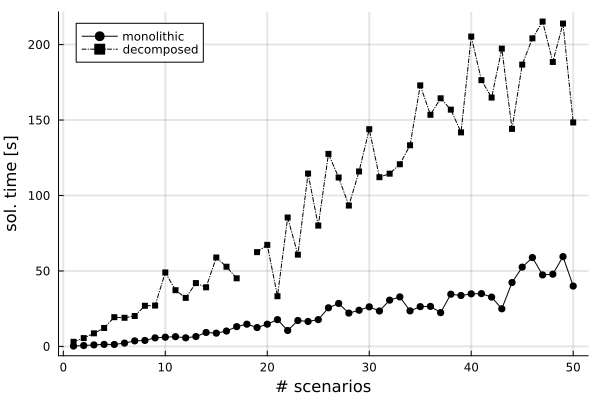

In [16]:
# solution time
p1 = plot(1:nScenMax,solTimeTraj_s[1,:],
    xlabel="# scenarios",
    ylabel="sol. time [s]",
    marker=:circle,
    markercolor = :black,
    linecolor = :black,
    label="monolithic")

p1 = plot!(1:nScenMax,solTimeTraj_s[2,:],
    marker=:square, 
    markercolor = :black,
    linecolor = :black,
    markersize = 3,
    linestyle = :dashdot,
    label="decomposed",
    gridlinewidth=2,
    dpi=600)

display(p1)
savefig(p1,"C:/Users/MACC-Jose/Documents/Canada/Papers/Benders Decomposition/Figures/C3_SolTime.pdf");

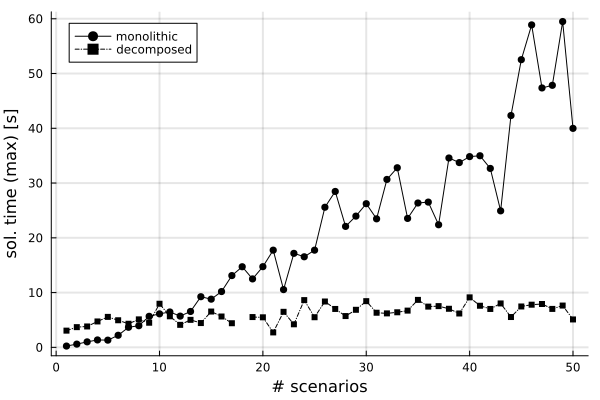

In [17]:
# solution time (parallel)
p1b = plot(1:nScenMax,solTimeTraj_s[1,:],
    xlabel="# scenarios", 
    ylabel="sol. time (max) [s]",
    marker=:circle, 
    markercolor = :black,
    linecolor = :black,
    label="monolithic")

p1b = plot!(1:nScenMax,solTimeMaxTraj_s,
    marker=:square, 
    markercolor = :black,
    linecolor = :black,
    markersize = 3,
    linestyle = :dashdot,
    label="decomposed",
    gridlinewidth=2,
    dpi=600)

display(p1b)
savefig(p1b,"C:/Users/MACC-Jose/Documents/Canada/Papers/Benders Decomposition/Figures/C3_SolTimePar.pdf");

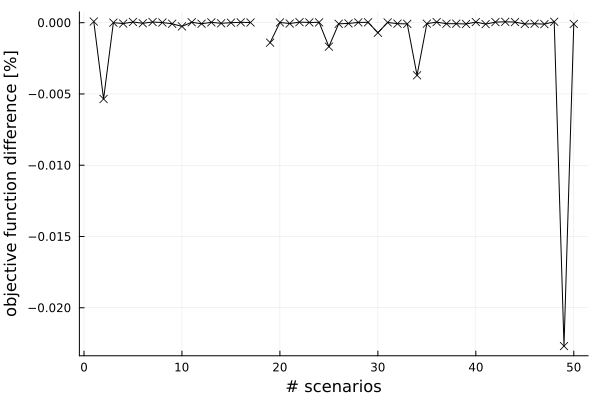

In [18]:
# objective function (parallel)
p2 = plot(1:nScenMax,100*(solObjTraj_s[2,:] - solObjTraj_s[1,:])./solObjTraj_s[1,:],
    xlabel="# scenarios", 
    ylabel="objective function difference [%]",
    marker=:xcross, 
    markercolor = :black,
    linecolor = :black,
    label="",
    dpi=600)

display(p2)
savefig(p2,"C:/Users/MACC-Jose/Documents/Canada/Papers/Benders Decomposition/Figures/C3_OFComp.pdf");

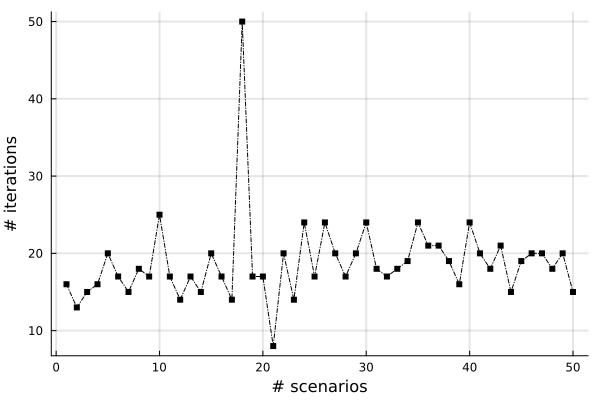

In [19]:
p3 = plot(1:nScenMax,iterTraj_s,xlabel="# scenarios", ylabel="# iterations",
    marker=:square, 
    markersize=3,
    linecolor = :black,
    markercolor = :black,
    linestyle = :dashdot,
    label="",
    yticks=range(0,150,step=10),
    gridlinewidth=2,
    dpi=600)

display(p3)
savefig(p3,"C:/Users/MACC-Jose/Documents/Canada/Papers/Benders Decomposition/Figures/C3_BenIter.pdf");

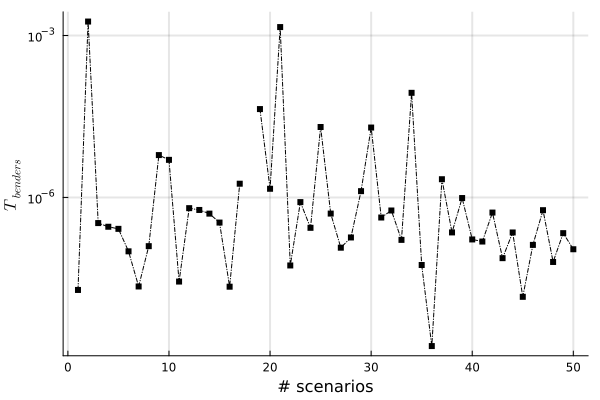

In [20]:
p4 = plot(1:nScenMax,optGapTraj_s,
    yscale=:log10,
    xlabel="# scenarios", 
    ylabel=L"T_{benders}",
    marker=:square, 
    markersize=3,
    linecolor = :black,
    markercolor = :black,
    linestyle = :dashdot,
    label="",
    gridlinewidth=2,
    dpi=600)

display(p4)
savefig(p4,"C:/Users/MACC-Jose/Documents/Canada/Papers/Benders Decomposition/Figures/C3_BenOptGap.pdf");

# Checking the performance of the methods in terms of time vs. nReac

In [21]:
# # testing the number of reactors in series (chosen arbitrarily as the same number of scenarios)
# nReactMax = nScenMax

# #preparing plot 
# # --> monolithic vs. decomposed 
# # solution time
# solTimeTraj_r = Matrix{Float64}(undef,2,nScenMax) 
# # computed objective function
# solObjTraj_r = Matrix{Float64}(undef,2,nScenMax) 
# # --> only decomposed
# # number of iterations
# iterTraj_r = Vector{Float64}(undef,nScenMax) 
# # optimality gap
# optGapTraj_r = Vector{Float64}(undef,nScenMax) 

# # number of reactors in parallel
# nScenarios = 2
# #equiprobable scenarios
# pScenarios = 1.0/nScenarios

# for rr = 1:nReactMax
#     display("evaluating $(rr) reactors in parallel | option $(opti)")
        
#     #number os reactors
#     nReac = rr
#     # Number of states
#     nx = 2*nReac
        
#     # Possible initial conditions (deviation form)
#     xInit_0 = repeat([0.3583;0.6418] .- x0, outer = [nReac,1])
#     uInit_0 = 1.0 - u0
       
#     # solving monolithical problem 
#     sol_m_Dict = MS_CLDRTO(xInit_0,uInit_0,nReac,nScenarios,pScenarios,solNominal,opti)

#     # solving decomposed problem    
#     sol_d_Dict = BENS_CLDRTO(xInit_0,uInit_0,nReac,nScenarios,pScenarios,solNominal,opti)
        
#     # for plotting
#     solTimeTraj_r[1,rr] = sol_m_Dict['t']
#     solTimeTraj_r[2,rr] = sol_d_Dict['t']
    
#     solObjTraj_r[1,rr] = sol_m_Dict['ϕ']
#     solObjTraj_r[2,rr] = sol_d_Dict['ϕ']

#     iterTraj_r[rr] = sol_d_Dict['i'] 
#     optGapTraj_r[rr] = sol_d_Dict['g']

# end


In [22]:
# # solution time
# p5 = plot(1:nReactMax,solTimeTraj_r[1,:],
#     xlabel="# reactors",
#     ylabel="sol. time [s]",
#     marker=:circle,
#     markercolor = :black,
#     linecolor = :black,
#     label="monolithic")

# p5 = plot!(1:nReactMax,solTimeTraj_r[2,:],
#     marker=:square, 
#     markercolor = :black,
#     linecolor = :black,
#     markersize = 3,
#     linestyle = :dashdot,
#     label="decomposed",
#     gridlinewidth=2,
#     dpi=600)

# display(p5)
# #savefig(p5,"C:/Users/MACC-Jose/Documents/Canada/Papers/Benders Decomposition/Figures/C3_SolTime.pdf");

In [23]:
# # objective function (parallel)
# p5b = plot(1:nReactMax,(solObjTraj_r[2,:] - solObjTraj_r[1,:])./solObjTraj_r[1,:],
#     xlabel="# reactors", 
#     ylabel="objective function difference [-]",
#     marker=:xcross, 
#     markercolor = :black,
#     linecolor = :black,
#     label="",
#     dpi=600)

# display(p5b)
# #savefig(p5b,"C:/Users/MACC-Jose/Documents/Canada/Papers/Benders Decomposition/Figures/C3_OFComp.pdf");

In [24]:
# p6 = plot(1:nReactMax,iterTraj_r,
#     xlabel="# reactors", 
#     ylabel="# iterations",
#     marker=:square, 
#     markersize=3,
#     linecolor = :black,
#     markercolor = :black,
#     linestyle = :dashdot,
#     label="",
#     yticks=range(0,150,step=10),
#     gridlinewidth=2,
#     dpi=600)

# display(p6)
# #savefig(p6,"C:/Users/MACC-Jose/Documents/Canada/Papers/Benders Decomposition/Figures/C3_BenIter.pdf");

In [25]:
# p8 = plot(1:nReactMax,optGapTraj_r,
#     yscale=:log10,
#     xlabel="# reactors", 
#     ylabel=L"T_{benders}",
#     marker=:square, 
#     markersize=3,
#     linecolor = :black,
#     markercolor = :black,
#     linestyle = :dashdot,
#     label="",
#     gridlinewidth=2,
#     dpi=600)

# display(p8)
# #savefig(p8,"C:/Users/MACC-Jose/Documents/Canada/Papers/Benders Decomposition/Figures/C3_BenOptGap.pdf");

# Checking if trajectories match for more scenarios and reactors
- arbitrarily chosen number of scenarios and reactors

In [26]:
nSCheck = 3 # number of scenarios
nRCheck = 5 # number of reactors in parallel
optiCheck = opti

# Extracting solution for plotting --> monolithic vs. decomposed 
yTraj = Array{Float64}(undef,2,pD,nSCheck)
uTraj = Array{Float64}(undef,2,pD,nSCheck) 
yspTraj = Array{Float64}(undef,2,pD,nSCheck) 

#equiprobable scenarios
pScheck = 1.0/nSCheck;

# Number of states
nx = 2*nRCheck;

# Initial conditions (deviation form)
xInit_0 = repeat([0.3583;0.6418] .- x0, outer = [nRCheck,1]);
uInit_0 = 1.0 - u0;

sol_mon = MS_CLDRTO(xInit_0,uInit_0,nRCheck,nSCheck,pScheck,solNominal,optiCheck)
sol_dec = BENS_CLDRTO(xInit_0,uInit_0,nRCheck,nSCheck,pScheck,solNominal,optiCheck)

for ii in 1:pD
    for ss in 1:nSCheck
    # transforming from deviation form
    yTraj[1,ii,ss] = sol_mon['y'][ii,ss] + y0
    yspTraj[1,ii,ss] = sol_mon['s'][ii,ss] + y0
    uTraj[1,ii,ss] = sol_mon['u'][ii,1,ss] + u0
        
    yTraj[2,ii,ss] = sol_dec['y'][ss][ii] + y0
    yspTraj[2,ii,ss] = sol_dec['s'][ss][ii] + y0
    uTraj[2,ii,ss] = sol_dec['u'][ss][1,ii] + u0    
    end
end;

" DB: opt gap = 1.044432237289717"

">>>>>> iteration 1:O"

" DB: opt gap = 0.9105382045332322"

">>>>>> iteration 2:O"

" DB: opt gap = 0.9478501241844854"

">>>>>> iteration 3:O"

" DB: opt gap = 0.9589027209085974"

">>>>>> iteration 4:O"

" DB: opt gap = 0.9217978277350534"

">>>>>> iteration 5:O"

" DB: opt gap = 0.8566851037256098"

">>>>>> iteration 6:O"

" DB: opt gap = 0.002384184927286266"

">>>>>> iteration 7:O"

" DB: opt gap = 0.0023831002819147745"

">>>>>> iteration 8:O"

">>>>>> iteration 9:F"

" DB: opt gap = 0.0023800297216452176"

">>>>>> iteration 10:O"

" DB: opt gap = 0.002379141256776528"

">>>>>> iteration 11:O"

" DB: opt gap = 0.0023144688937863983"

">>>>>> iteration 12:O"

" DB: opt gap = 0.002313694866705736"

">>>>>> iteration 13:O"

" DB: opt gap = 0.0023114238826199163"

">>>>>> iteration 14:O"

" DB: opt gap = 0.0023072424020102464"

">>>>>> iteration 15:O"

" DB: opt gap = 0.002306364654862833"

">>>>>> iteration 16:O"

" DB: opt gap = 0.002303690369633236"

">>>>>> iteration 17:O"

" DB: opt gap = 3.295741125757793e-8"

In [27]:
# time series for plotting
ts = Vector{Float64}(undef,pD) 
for i in 1:pD
    ts[i] = 1*i
end

# Creating color array
CList = reshape( range(colorant"red", stop=colorant"blue",length=nSCheck), 1, nSCheck);
MList =[:cross, :circle];

Plot Recipe

In [28]:
@userplot Plot_Comp
@recipe function f(h::Plot_Comp)
        
if length(h.args) < 7
        y_lim, ylab, lineT, x, y, y_ub = h.args
    else
        y_lim, ylab, lineT, x, y, y_ub, y_lb = h.args
    end
    
    # set up the subplots
    # these are common to both marginal histograms
    layout := (3,1)
    grid := true
    gridlinewidth --> 2
    latex := true
    linecolor := :black
    
    for ss = 1:3
        # limits
        ylimits := y_lim
        
        # labels 
        ylabel := ylab
        if ss == 3
            xlabel := "time [min]"
        end
        
        # DATA PLOTTING
        # upper bound
        @series begin
            seriestype := :path
            linestyle := :dot
            subplot := ss
        
            if ss == 1
                label --> "Limit"
            else
                label --> ""
            end
            
            x, y_ub*ones(length(x))
        end

        if length(h.args) > 6 
            # lower bound
            @series begin
                seriestype := :path
                linestyle := :dot
                subplot := ss
                label --> ""
                
                x, y_lb*ones(length(x))
            end
        end

        labels = ["Mono.", "Deco."]
        for mm = 1:2
            # average MC value
            @series begin
                if lineT == 2
                    seriestype := :steppre
                else
                    seriestype := :path
                end
                linewidth := 3
                subplot := ss

                markercolor := :black
                markerstrokecolor := :black
                markersize := 3

                if ss == 1
                    label --> labels[mm]
                else
                    label --> ""
                end

                if mm == 1
                    linestyle := :solid
                    markershape := :circle
                else
                    linestyle := :dashdot
                    markershape := :rect
                end

                x, y[mm,:,ss]
            end
        end
    end # mono/dec loop
end;

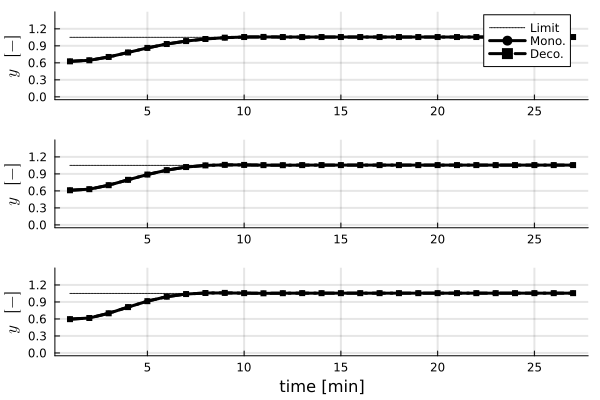

In [29]:
plot_comp((-0.05,1.5),L"y \quad [-]",1,ts,yTraj,(pUB + y0))

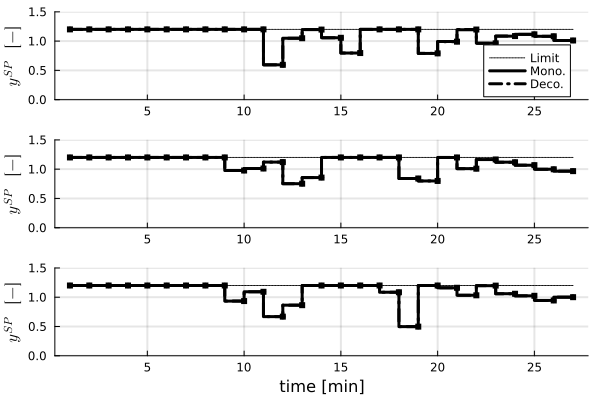

In [30]:
plot_comp((0.0,1.5),L"y^{SP} \quad [-]",2,ts,yspTraj,yspMax)

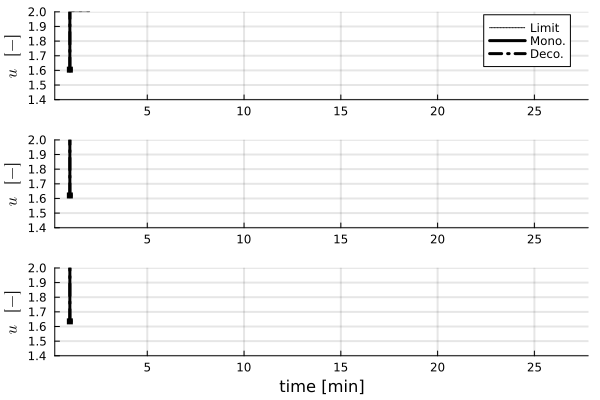

In [31]:
plot_comp((1.4,2.0),L"u \quad [-]",2,ts,uTraj,uMax)

Creating table to show the results

In [32]:
# Scenarios
table_iter = Any[]
table_solTime_M = Any[]
table_solTime_D = Any[]
table_solMax = Any[]
table_of_M = Any[]
table_of_D = Any[]
table_perChange = Any[]

for tt in [5 10 15 20 25 30 40 50] 
    push!(table_iter, tt)
    push!(table_solTime_M, solTimeTraj_s[1,tt])
    push!(table_solTime_D, solTimeTraj_s[2,tt])
    push!(table_solMax, solTimeMaxTraj_s[tt])
    push!(table_of_M, -solObjTraj_s[1,tt])
    push!(table_of_D, -solObjTraj_s[2,tt])
    push!(table_perChange, 100*(solObjTraj_s[2,tt] - solObjTraj_s[1,tt])/solObjTraj_s[1,tt])
end

df_scen = DataFrame(; iter = table_iter, 
                sol_time_M = table_solTime_M, 
                 sol_time_D = table_solTime_D,
                 sol_time_D_max = table_solMax,
                 comp_of_M = table_of_M,
                 comp_of_D = table_of_D,
                 per_change = table_perChange);

In [33]:
display("Analysis: # of Scenarios")
display(df_scen)


"Analysis: # of Scenarios"

Row,iter,sol_time_M,sol_time_D,sol_time_D_max,comp_of_M,comp_of_D,per_change
,Any,Any,Any,Any,Any,Any,Any
1,5,1.312,19.377,5.56,5.52689,5.52689,4.88126e-5
2,10,6.117,49.006,7.957,5.53029,5.53028,-0.000259742
3,15,8.797,58.907,6.536,5.53039,5.53039,4.24427e-8
4,20,14.731,67.285,5.483,5.53063,5.53063,1.85961e-5
5,25,17.743,80.05,5.498,5.53085,5.53076,-0.00168117
6,30,26.229,143.929,8.433,5.53088,5.53085,-0.000705558
7,40,34.828,205.3,9.127,5.53108,5.53109,4.40926e-5
8,50,39.984,148.396,5.093,5.5313,5.5313,-8.82168e-5
